In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import logging
from typing import Dict, List, Tuple, Optional
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Project setup
PROJECT_ROOT = r'C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids'
os.chdir(PROJECT_ROOT)
src_path = os.path.join(PROJECT_ROOT, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Imports
from config import load_config, Config
from lcoe_calc import (
    compare_datacenter_power_systems,
    calculate_solar_storage_lcoe,
    calculate_gas_system_lcoe,
    calculate_gpu_idling_costs,
    get_state_from_coords,
    GRID_BASELINE_DATA
)
from microgrid_optimizer import MicrogridOptimizer, SystemCosts
from datacenter_analyzer import DatacenterAnalyzer
from natgas_system_tool import NGPowerPlantCalculator, TURBINE_LIBRARY, generate_plant_configurations

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Cell B  ── Helper to edit a PlantConfiguration timeline (NEW CELL)

from copy import deepcopy

def scale_construction_timeline(
    plant_config,
    factor: float | None = None,
    zero_turbine_wait: bool = False
):
    """
    Return a *copy* of plant_config with its construction timeline edited.

    factor
        Multiplicative factor applied to construction_years and (optionally)
        turbine_lead_time.  Use None to leave duration unchanged.

    zero_turbine_wait
        If True, set turbine_lead_time to 0 before any scaling.
    """
    pc = deepcopy(plant_config)
    tl = deepcopy(pc.construction_timeline)  # assume dict-like

    # 1)  eliminate turbine wait if requested
    if zero_turbine_wait and 'turbine_lead_time' in tl:
        tl['turbine_lead_time'] = 0

    # 2)  scale everything if requested
    if factor is not None:
        tl['construction_years'] = tl['construction_years'] * factor
        tl['total_months'] = tl['construction_years'] * 12
        if 'turbine_lead_time' in tl:
            tl['turbine_lead_time'] = tl['turbine_lead_time'] * factor

    pc.construction_timeline = tl
    return pc

Setting up scenario
✓ Facility Load calculated: 27.4 MW Design Load
Optimizing microgrid design (this may take a few minutes)...
✓ Optimization complete: 179 MW Solar / 130 MW Battery

Calculating LCOE with 4-point interpolation...
✓ Interpolated LCOE: $0.21191/kWh

Calculating LCOE with brute-force yearly simulation (this will be slow)...


Simulating each operational year:   0%|          | 0/25 [00:00<?, ?it/s]

✓ Brute-Force LCOE: $0.21187/kWh

--- LCOE COMPARISON ---
Original Interpolated LCOE: $0.21191
Recalc Interpolated LCOE:   $0.21191
Brute-Force LCOE:           $0.21187
Error Percentage:           0.018%
Thermal load variation:     0.3% of Year 0 baseline
--------------------

--- INTERPOLATION DEBUG ---
Anchor energies from optimizer:
Year 0: 177821.7 MWh
Year 13: 177352.5 MWh
Year 14: 177631.1 MWh
Year 25: 177045.0 MWh

Thermal parasitic: 1356.0 MWh

Fixed interpolated energy (key years):
Op Year 0: 176465.7 MWh
Op Year 12: 175996.4 MWh
Op Year 13: 176275.1 MWh
Op Year 24: 175689.0 MWh


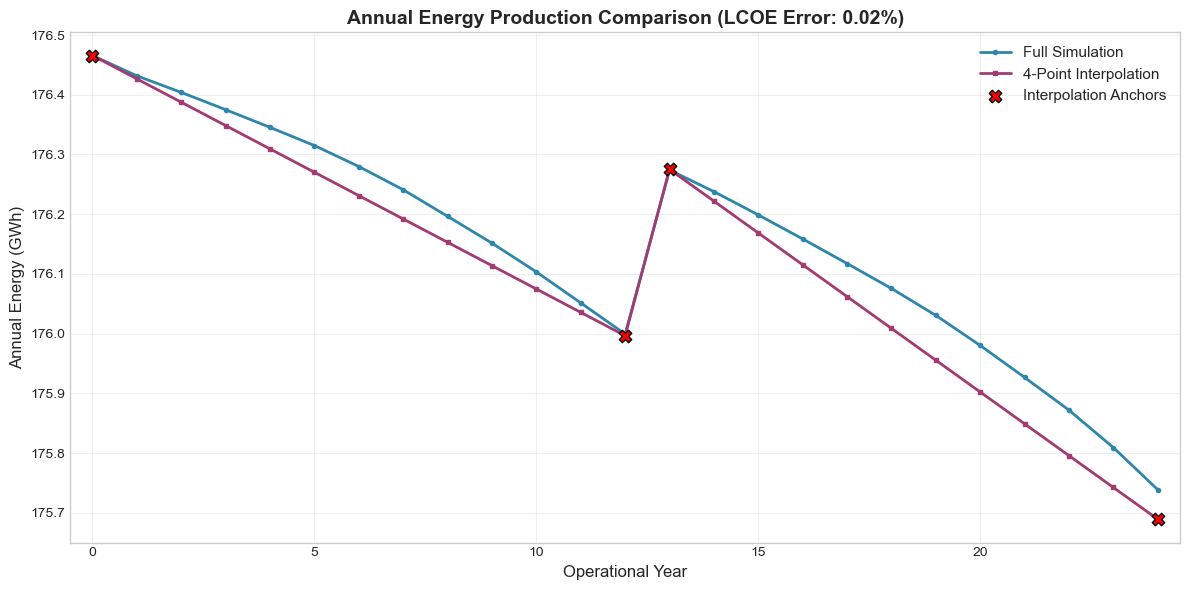


Max absolute error: 0.08 GWh
Mean absolute error: 0.04 GWh
Thermal load range: 1353.08 - 1357.14 MWh/year


In [37]:
# Cell 2: LCOE Interpolation vs. Full Simulation (Corrected)
from degradation_model import (
    get_solar_capacity_factor, 
    get_battery_capacity_at_year, 
    extract_battery_year_0_stats,
    interpolate_annual_energy,
    calculate_thermal_profile
)
from pvstoragesim import evaluate_system
from lcoe_calc import calculate_npv
from tqdm.notebook import tqdm
import matplotlib.ticker as mticker

def interpolate_operational_energy(sim_year_0, sim_year_13, sim_year_14, sim_year_25, year_0_stats, max_op_years=25):
    """
    Simple interpolation in operational years only.
    """
    # Get thermal parasitic load
    thermal_mwh = year_0_stats.get('thermal_parasitic_kwh', 0.0) / 1000
    
    # FIXED: Anchor points (operational years) - variable names don't match the op years they represent
    anchors = {
        0: sim_year_0.load_served_mwh - thermal_mwh,
        12: sim_year_13.load_served_mwh - thermal_mwh,   # sim_year_13 has op year 12 factors
        13: sim_year_14.load_served_mwh - thermal_mwh,   # sim_year_14 has op year 13 factors
        24: sim_year_25.load_served_mwh - thermal_mwh    # sim_year_25 has op year 24 factors
    }
    
    energy = np.zeros(max_op_years)
    
    # Set anchor points
    for year, val in anchors.items():
        if year < max_op_years:
            energy[year] = val
    
    # Interpolate between anchors
    anchor_years = sorted(anchors.keys())
    
    for i in range(len(anchor_years) - 1):
        start_year = anchor_years[i]
        end_year = anchor_years[i + 1]
        start_energy = anchors[start_year]
        end_energy = anchors[end_year]
        
        # Linear interpolation between anchor points
        for year in range(start_year + 1, min(end_year, max_op_years)):
            fraction = (year - start_year) / (end_year - start_year)
            energy[year] = start_energy * (1 - fraction) + end_energy * fraction
    
    return energy

# --- 1. Define the Scenario ---
print("Setting up scenario")
GPUS = 20_000
LATITUDE, LONGITUDE = 33.45, -112.07 # Phoenix, AZ
ARCHITECTURE = "ac_coupled" 
config = load_config()

# --- 2. Get Location-Specific Facility Load ---
analyzer = DatacenterAnalyzer(latitude=LATITUDE, longitude=LONGITUDE, total_gpus=GPUS, config=config)
facility_load = analyzer.calculate_facility_load(required_uptime_pct=99.0)
print(f"✓ Facility Load calculated: {facility_load.facility_load_design_mw:.1f} MW Design Load")

# --- 3. Optimize the Solar+Storage System ---
print("Optimizing microgrid design (this may take a few minutes)...")
costs = SystemCosts(
    solar_cost_per_kw=config.costs.solar_cost_y0,
    battery_cost_per_kw=config.costs.bess_cost_y0,
    solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
    battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
)
optimizer = MicrogridOptimizer(
    latitude=LATITUDE, longitude=LONGITUDE, facility_load=facility_load,
    required_uptime_pct=99.0, costs=costs, architecture=ARCHITECTURE,
    efficiency_params=config
)
opt_result = optimizer.optimize()
print(f"✓ Optimization complete: {opt_result.solar_mw:.0f} MW Solar / {opt_result.battery_mw:.0f} MW Battery")

# --- 4. Calculate LCOE using the 4-Point Interpolation Method ---
print("\nCalculating LCOE with 4-point interpolation...")
interp_lcoe_result = calculate_solar_storage_lcoe(
    system_type=ARCHITECTURE,
    solar_mw=opt_result.solar_mw,
    battery_mw=opt_result.battery_mw,
    battery_mwh=opt_result.battery_mwh,
    land_acres=opt_result.land_area_acres,
    sim_year_0=opt_result.sim_year_0,
    sim_year_13=opt_result.sim_year_13,
    sim_year_14=opt_result.sim_year_14,
    sim_year_25=opt_result.sim_year_25,
    year_0_stats=opt_result.year_0_stats,
    construction_years=config.design.solar_construction_years,
    required_uptime_pct=99.0,
    config=config
)
interp_lcoe = interp_lcoe_result.lcoe
print(f"✓ Interpolated LCOE: ${interp_lcoe:.5f}/kWh")

# --- 5. Calculate LCOE using the Brute-Force Yearly Simulation Method ---
print("\nCalculating LCOE with brute-force yearly simulation (this will be slow)...")

# Work in operational years only
max_op_years = 25  # 0-24 operational years
brute_force_op_energy = np.zeros(max_op_years)
thermal_loads = []

# Get interpolated energy using our fixed function
interp_op_energy = interpolate_operational_energy(
    opt_result.sim_year_0, opt_result.sim_year_13, opt_result.sim_year_14, 
    opt_result.sim_year_25, opt_result.year_0_stats, max_op_years
)

# FIXED: Calculate brute force in operational years
for op_year in tqdm(range(max_op_years), desc="Simulating each operational year"):
    solar_deg_factor = get_solar_capacity_factor(op_year, config)
    
    # FIXED: Battery replacement logic
    if op_year < 13:  # Original battery years 0-12
        battery_deg_factor = get_battery_capacity_at_year(op_year, opt_result.year_0_stats, config)
    else:  # Replacement battery years 13-24
        replacement_battery_age = op_year - 13
        battery_deg_factor = get_battery_capacity_at_year(replacement_battery_age, opt_result.year_0_stats, config)

    sim = evaluate_system(
        latitude=LATITUDE, longitude=LONGITUDE,
        solar_capacity_mw=opt_result.solar_mw * solar_deg_factor,
        battery_power_mw=opt_result.battery_mw * battery_deg_factor,
        facility_load=facility_load, architecture=ARCHITECTURE,
        efficiency_params=config, solar_profile=optimizer.solar_profile,
        return_hourly=True
    )
    
    # Calculate thermal load
    thermal_data = calculate_thermal_profile(sim, facility_load, config)
    annual_thermal_mwh = thermal_data['annual_thermal_kwh'] / 1000
    thermal_loads.append(annual_thermal_mwh)
    
    brute_force_op_energy[op_year] = sim.load_served_mwh - annual_thermal_mwh

# Convert back to calendar years for NPV calculation (for LCOE comparison)
ops_start_year = int(np.ceil(config.design.solar_construction_years))
brute_force_annual_energy = np.zeros(config.financial.evaluation_years)
interp_annual_energy = np.zeros(config.financial.evaluation_years)

for op_year in range(max_op_years):
    cal_year = ops_start_year + op_year
    if cal_year < config.financial.evaluation_years:
        brute_force_annual_energy[cal_year] = brute_force_op_energy[op_year]
        interp_annual_energy[cal_year] = interp_op_energy[op_year]

# Calculate final LCOEs
brute_force_energy_npv = calculate_npv(brute_force_annual_energy, config.financial.discount_rate)
interp_energy_npv = calculate_npv(interp_annual_energy, config.financial.discount_rate)
total_cost_npv = interp_lcoe_result.capex_npv + interp_lcoe_result.opex_npv
brute_force_lcoe = (total_cost_npv / brute_force_energy_npv) / 1000
recalc_interp_lcoe = (total_cost_npv / interp_energy_npv) / 1000

print(f"✓ Brute-Force LCOE: ${brute_force_lcoe:.5f}/kWh")

# --- 6. Compare Results ---
error_pct = ((recalc_interp_lcoe - brute_force_lcoe) / brute_force_lcoe) * 100

print("\n--- LCOE COMPARISON ---")
print(f"Original Interpolated LCOE: ${interp_lcoe:.5f}")
print(f"Recalc Interpolated LCOE:   ${recalc_interp_lcoe:.5f}")
print(f"Brute-Force LCOE:           ${brute_force_lcoe:.5f}")
print(f"Error Percentage:           {error_pct:.3f}%")

# Thermal validation
y0_thermal = opt_result.year_0_stats.get('thermal_parasitic_kwh', 0.0) / 1000
thermal_variation = (np.max(thermal_loads) - np.min(thermal_loads)) / y0_thermal * 100 if y0_thermal > 0 else 0
print(f"Thermal load variation:     {thermal_variation:.1f}% of Year 0 baseline")
print("--------------------")

# Debug the interpolation
print("\n--- INTERPOLATION DEBUG ---")
print("Anchor energies from optimizer:")
print(f"Year 0: {opt_result.sim_year_0.load_served_mwh:.1f} MWh")
print(f"Year 13: {opt_result.sim_year_13.load_served_mwh:.1f} MWh") 
print(f"Year 14: {opt_result.sim_year_14.load_served_mwh:.1f} MWh")
print(f"Year 25: {opt_result.sim_year_25.load_served_mwh:.1f} MWh")

print(f"\nThermal parasitic: {y0_thermal:.1f} MWh")

print("\nFixed interpolated energy (key years):")
print(f"Op Year 0: {interp_op_energy[0]:.1f} MWh")
print(f"Op Year 12: {interp_op_energy[12]:.1f} MWh")  # FIXED: Changed from 13 to 12
print(f"Op Year 13: {interp_op_energy[13]:.1f} MWh")  # FIXED: Changed from 14 to 13  
print(f"Op Year 24: {interp_op_energy[24]:.1f} MWh")

# Plot in operational years
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
op_years = np.arange(max_op_years)

ax.plot(op_years, brute_force_op_energy / 1000, 'o-', 
        label='Full Simulation', markersize=3, linewidth=2, color='#2E86AB')
ax.plot(op_years, interp_op_energy / 1000, 's-', 
        label='4-Point Interpolation', markersize=3, linewidth=2, color='#A23B72')

# FIXED: Highlight anchor points (operational years)
anchor_op_years = [0, 12, 13, 24]  # FIXED: Changed from [0, 13, 14, 24]
valid_anchors = [y for y in anchor_op_years if y < max_op_years]
ax.scatter(valid_anchors, interp_op_energy[valid_anchors] / 1000, 
          s=80, color='red', marker='X', zorder=10, edgecolor='black', linewidth=1,
          label='Interpolation Anchors')

ax.set_title(f'Annual Energy Production Comparison (LCOE Error: {error_pct:.2f}%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Operational Year', fontsize=12)
ax.set_ylabel('Annual Energy (GWh)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, max_op_years - 0.5)

plt.tight_layout()
plt.show()

# Error statistics
error_gwh = (interp_op_energy - brute_force_op_energy) / 1000
print(f"\nMax absolute error: {np.max(np.abs(error_gwh)):.2f} GWh")
print(f"Mean absolute error: {np.mean(np.abs(error_gwh)):.2f} GWh")
print(f"Thermal load range: {np.min(thermal_loads):.2f} - {np.max(thermal_loads):.2f} MWh/year")

In [5]:
# Cell 2: Configuration
LOCATION = {
    'name': 'SE Colorado',
    'latitude': 37.5,
    'longitude': -103.5
}

FACILITY_SCALES = [24000, 100000, 500000]
REQUIRED_UPTIME = 99.0

print(f"Configuration:")
print(f"  Location: {LOCATION['name']}")
print(f"  Scales: {[f'{s//1000}K' for s in FACILITY_SCALES]} GPUs")
print(f"  Uptime: {REQUIRED_UPTIME}%")

# Get location-specific parameters
state = get_state_from_coords(LOCATION['latitude'], LOCATION['longitude'])
if state and state in GRID_BASELINE_DATA:
    _, _, electricity_price, gas_price = GRID_BASELINE_DATA[state]
    print(f"  Natural gas: ${gas_price:.2f}/MMBtu")
    LOCATION_GAS_PRICE = gas_price
else:
    LOCATION_GAS_PRICE = 3.5

Configuration:
  Location: SE Colorado
  Scales: ['24K', '100K', '500K'] GPUs
  Uptime: 99.0%
Loading formatted geocoded file...
  Natural gas: $7.70/MMBtu


In [38]:
# Cell A  ── Financial / technical parameters (REPLACE ENTIRE CELL)

def get_financial_parameters():
    """
    Parameter master list – now includes natural-gas construction-
    timeline bundle:
        1. ng_construction_time      (0.5× .. 2.0× baseline)
        2. ng_perfect_coordination   (flag – zero turbine wait)
    """

    parameters = {
        # ------------------------------------------------------------------
        # CAPITAL COSTS (±20 %)
        # ------------------------------------------------------------------
        'solar_cost_y0': {
            'path': ['costs', 'solar_cost_y0'],
            'name': 'Solar Module Cost',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar', 'dc_solar']
        },
        'bess_cost_y0': {
            'path': ['costs', 'bess_cost_y0'],
            'name': 'Battery Cost Y0',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar', 'dc_solar']
        },
        'bess_cost_y15': {
            'path': ['costs', 'bess_cost_y15'],
            'name': 'Battery Cost Y15',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar', 'dc_solar']
        },
        'solar_bos_cost_y0_ac': {
            'path': ['costs', 'solar_bos_cost_y0_ac'],
            'name': 'Solar BOS AC',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar']
        },
        'solar_bos_cost_y0_dc': {
            'path': ['costs', 'solar_bos_cost_y0_dc'],
            'name': 'Solar BOS DC',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['dc_solar']
        },
        'battery_bos_cost_y0_ac': {
            'path': ['costs', 'battery_bos_cost_y0_ac'],
            'name': 'Battery BOS AC',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar']
        },
        'battery_bos_cost_y0_dc': {
            'path': ['costs', 'battery_bos_cost_y0_dc'],
            'name': 'Battery BOS DC',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['dc_solar']
        },
        'land_cost_per_sq_km': {
            'path': ['costs', 'land_cost_per_sq_km'],
            'name': 'Land Cost',
            'type': 'percentage',
            'values': [0.5, 2],
            'affects': ['ac_solar', 'dc_solar']
        },
 
       
        # ------------------------------------------------------------------
        # O&M COSTS  (±20 %)
        # ------------------------------------------------------------------
        'solar_fixed_om': {
            'path': ['costs', 'solar_fixed_om'],
            'name': 'Solar Fixed O&M',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar', 'dc_solar']
        },
        'storage_fixed_om': {
            'path': ['costs', 'storage_fixed_om'],
            'name': 'Storage Fixed O&M',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['ac_solar', 'dc_solar']
        },

        # ------------------------------------------------------------------
        # FINANCIAL PARAMETERS
        # ------------------------------------------------------------------
        'gpu_hour_spot_price': {
            'path': ['costs', 'gpu_hour_spot_price'],
            'name': 'GPU Idling Cost',
            'type': 'bounds',
            'values': [1.00, 4.00],
            'affects': ['ac_solar', 'dc_solar', 'natural_gas']
        },
        'discount_rate': {
            'path': ['financial', 'discount_rate'],
            'name': 'Discount Rate',
            'type': 'bounds',
            'values': [0.03, 0.12],
            'affects': ['ac_solar', 'dc_solar', 'natural_gas']
        },

        # ------------------------------------------------------------------
        # CONSTRUCTION TIMELINES (SOLAR)
        # ------------------------------------------------------------------
        'solar_construction_years': {
            'path': ['design', 'solar_construction_years'],
            'name': 'Solar Construction Time',
            'type': 'percentage',
            'values': [.75, 1.5],
            'affects': ['ac_solar', 'dc_solar']
        },

        # ------------------------------------------------------------------
        # NATURAL-GAS COSTS  &  NEW CONSTRUCTION-BUNDLE
        # ------------------------------------------------------------------
        'gas_price_location': {
            'path': None,
            'name': 'Natural Gas Price',
            'type': 'bounds',
            'values': [3.01, 12.75],
            'affects': ['natural_gas']
        },
        'ng_capex': {
            'path': None,
            'name': 'NG CapEx',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['natural_gas']
        },
        'ng_fixed_om': {
            'path': None,
            'name': 'NG Fixed O&M',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['natural_gas']
        },
        'ng_var_om': {
            'path': None,
            'name': 'NG Variable O&M',
            'type': 'percentage',
            'values': [0.8, 1.2],
            'affects': ['natural_gas']
        },

        # ---------- NEW ----------
        'ng_construction_time': {
            'path': None,
            'name': 'NG Construction Time',
            'type': 'percentage',      # treat as multiplier (0.5× .. 2×)
            'values': [0.5, 1.25],
            'affects': ['natural_gas']
        },
        'ng_perfect_coordination': {
            'path': None,
            'name': 'NG Perfect Coordination',
            'type': 'flag',            # handled manually; values act as booleans
            'values': [False, True],
            'affects': ['natural_gas']
        },
        # -------------------------
        'turbine_lead_time': {        # keeps original “multiplier” param
            'path': None,
            'name': 'Turbine Lead Time',
            'type': 'percentage',
            'values': [0.66, 1.33],
            'affects': ['natural_gas']
        }
    }

    return parameters
def test_parameter_definitions():
    """Extended unit-test: now accepts a third param-type ‘flag’."""
    print("\n" + "="*60)
    print("TESTING PARAMETER DEFINITIONS")
    print("="*60)

    params = get_financial_parameters()

    # ------------------------------------------------------------------
    # 1.  Field-level checks
    # ------------------------------------------------------------------
    valid_types = ['percentage', 'bounds', 'flag']    # ← added ‘flag’

    for param_name, param_info in params.items():
        required_fields = ['name', 'type', 'values', 'affects']
        for field in required_fields:
            assert field in param_info, f"Parameter {param_name} missing field: {field}"

        # basic values checks
        assert len(param_info['values']) == 2, (
            f"Parameter {param_name} should have exactly 2 values"
        )
        assert param_info['values'][0] != param_info['values'][1], (
            f"Parameter {param_name} values should be different"
        )

        # allowed types
        assert param_info['type'] in valid_types, (
            f"Parameter {param_name} has invalid type: {param_info['type']}"
        )

        # affects
        assert len(param_info['affects']) > 0, (
            f"Parameter {param_name} should affect at least one system"
        )

    # ------------------------------------------------------------------
    # 2.  Make sure every system has at least one parameter
    # ------------------------------------------------------------------
    all_systems = set()
    for param_info in params.values():
        all_systems.update(param_info['affects'])

    expected_systems = {'ac_solar', 'dc_solar', 'natural_gas'}
    assert expected_systems.issubset(all_systems), (
        f"Missing systems in parameters: {expected_systems - all_systems}"
    )

    print(f"✓ {len(params)} parameters defined correctly")
    print(f"✓ Systems covered: {sorted(all_systems)}")

    # Highlight NG parameters that need manual handling
    ng_dynamic = [
        name for name, info in params.items()
        if info['path'] is None and 'natural_gas' in info['affects']
    ]
    print(f"✓ NG parameters needing dynamic paths: {ng_dynamic}")

    return params


# Instantiate parameters (rerun this cell after replacement)
parameters = test_parameter_definitions()
print(f"\nTotal parameters: {len(parameters)}")




TESTING PARAMETER DEFINITIONS
✓ 20 parameters defined correctly
✓ Systems covered: ['ac_solar', 'dc_solar', 'natural_gas']
✓ NG parameters needing dynamic paths: ['gas_price_location', 'ng_capex', 'ng_fixed_om', 'ng_var_om', 'ng_construction_time', 'ng_perfect_coordination', 'turbine_lead_time']

Total parameters: 20


In [6]:
def extract_baseline_designs():
    """Run optimization once for each scale and cache all needed data including actual NG plant configs."""
    from natgas_system_tool import NGPowerPlantCalculator, TURBINE_LIBRARY
    
    baseline_designs = {}
    
    for gpu_count in FACILITY_SCALES:
        print(f"\nOptimizing {gpu_count:,} GPUs")
        
        # Create analyzer and facility load
        analyzer = DatacenterAnalyzer(
            latitude=LOCATION['latitude'],
            longitude=LOCATION['longitude'],
            total_gpus=gpu_count
        )
        facility_load = analyzer.calculate_facility_load(required_uptime_pct=REQUIRED_UPTIME)
        config = load_config()
        
        # Create cost objects
        ac_costs = SystemCosts(
            solar_cost_per_kw=config.costs.solar_cost_y0,
            battery_cost_per_kw=config.costs.bess_cost_y0,
            solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
            battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
        )
        dc_costs = SystemCosts(
            solar_cost_per_kw=config.costs.solar_cost_y0,
            battery_cost_per_kw=config.costs.bess_cost_y0,
            solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_dc,
            battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_dc
        )
        
        # Run optimizations
        ac_optimizer = MicrogridOptimizer(
            latitude=LOCATION['latitude'], longitude=LOCATION['longitude'],
            facility_load=facility_load, required_uptime_pct=REQUIRED_UPTIME,
            costs=ac_costs, architecture="ac_coupled", efficiency_params=config, verbose=False
        )
        ac_result = ac_optimizer.optimize()
        
        dc_optimizer = MicrogridOptimizer(
            latitude=LOCATION['latitude'], longitude=LOCATION['longitude'],
            facility_load=facility_load, required_uptime_pct=REQUIRED_UPTIME,
            costs=dc_costs, architecture="dc_coupled", efficiency_params=config, verbose=False
        )
        dc_result = dc_optimizer.optimize()
        
        # FIXED: Get NG configuration using the EXACT same path as compare_datacenter_power_systems
        print(f"  Getting NG configuration using PowerSystemOptimizer...")
        
        try:
            from microgrid_optimizer import PowerSystemOptimizer
            
            power_optimizer = PowerSystemOptimizer(
                latitude=LOCATION['latitude'],
                longitude=LOCATION['longitude'], 
                facility_load=facility_load,
                required_uptime_pct=REQUIRED_UPTIME,
                costs=ac_costs,  # Use AC costs as reference
                efficiency_params=config
            )
            
            # Use the exact same optimization call as the baseline
            gas_optimization_result, best_gas_config = power_optimizer.optimize_natural_gas(LOCATION_GAS_PRICE)
            
            # Extract turbine information from the actual config
            turbine_key = None
            turbine_class = best_gas_config.turbine_class
            is_combined_cycle = (best_gas_config.cycle_type == 'CC')
            
            # Find the turbine key by matching the model name
            for key, turbine in TURBINE_LIBRARY.items():
                if turbine.model == best_gas_config.turbine_model:
                    turbine_key = key
                    break
            
            if turbine_key is None:
                print(f"Available turbine models: {[t.model for t in TURBINE_LIBRARY.values()]}")
                raise ValueError(f"Could not find turbine key for model '{best_gas_config.turbine_model}'")
            
            # Determine NREL reference key
            if turbine_class == 'aero':
                nrel_reference = 'aero_sc'
            elif turbine_class == 'f_class':
                nrel_reference = 'f_class_cc' if is_combined_cycle else 'f_class_sc'
            elif turbine_class == 'h_class':
                nrel_reference = 'h_class_cc'
            else:
                raise ValueError(f"Unknown turbine class: {turbine_class}")
            
            # Calculate baseline LCOE using the selected configuration
            baseline_ng_lcoe = calculate_gas_system_lcoe(
                plant_config=best_gas_config,
                gas_price=LOCATION_GAS_PRICE,
                facility_load=facility_load,
                config=config,
                construction_years=best_gas_config.construction_timeline.get('construction_years', 3.0)
            )
            
            # Create ng_params for backward compatibility
            fleet_desc = f"{best_gas_config.n_units}× {best_gas_config.turbine_model} {best_gas_config.cycle_type}"
            ng_params = {
                'fleet_description': fleet_desc,
                'nameplate_capacity_mw': best_gas_config.total_capacity_mw,
                'required_capacity_mw': power_optimizer.facility_load.facility_load_design_mw,
                'efficiency_lhv': best_gas_config.efficiency,
                'unit_capacity_mw': best_gas_config.unit_capacity_mw,
                'n_units': best_gas_config.n_units,
                'capex_per_kw': best_gas_config.capex_per_kw,
                'fixed_om_per_kw_yr': best_gas_config.fixed_om_per_kw_yr,
                'var_om_per_mwh': best_gas_config.var_om_per_mwh,
                'construction_years': best_gas_config.construction_timeline.get('construction_years', 3.0)
            }
            
        except Exception as e:
            print(f"Error getting NG configuration for {gpu_count} GPUs: {e}")
            print(f"Falling back to compare_datacenter_power_systems method...")
            
            # Fallback to the original method
            comparison = compare_datacenter_power_systems(
                total_gpus=gpu_count,
                required_uptime_pct=REQUIRED_UPTIME,
                location=(LOCATION['latitude'], LOCATION['longitude']),
                gas_price=LOCATION_GAS_PRICE
            )
            
            baseline_ng_lcoe = comparison.natural_gas
            
            # Parse configuration string as before
            config_str = comparison.ng_configuration
            parts = config_str.split('×')
            if len(parts) != 2:
                raise ValueError(f"Unexpected configuration format: {config_str}")
            
            turbine_info = parts[1].strip()
            is_combined_cycle = 'CC' in turbine_info
            turbine_model_name = turbine_info.replace(' CC', '').replace(' SC', '').strip()
            
            turbine_key = None
            turbine_class = None
            for key, turbine in TURBINE_LIBRARY.items():
                if turbine.model == turbine_model_name:
                    turbine_key = key
                    turbine_class = turbine.turbine_class
                    break
            
            if turbine_key is None:
                raise ValueError(f"Could not find turbine key for model '{turbine_model_name}'")
            
            if turbine_class == 'aero':
                nrel_reference = 'aero_sc'
            elif turbine_class == 'f_class':
                nrel_reference = 'f_class_cc' if is_combined_cycle else 'f_class_sc'
            elif turbine_class == 'h_class':
                nrel_reference = 'h_class_cc'
            else:
                raise ValueError(f"Unknown turbine class: {turbine_class}")
            
            # Create placeholder ng_params and best_gas_config
            ng_params = {'fleet_description': config_str}
            best_gas_config = None
        
        # Calculate solar LCOEs
        try:
            ac_lcoe = calculate_solar_storage_lcoe(
                system_type='ac_coupled', 
                solar_mw=ac_result.solar_mw, 
                battery_mw=ac_result.battery_mw,
                battery_mwh=ac_result.battery_mwh, 
                land_acres=ac_result.land_area_acres,
                sim_year_0=ac_result.sim_year_0, 
                sim_year_13=ac_result.sim_year_13,
                sim_year_14=ac_result.sim_year_14, 
                sim_year_25=ac_result.sim_year_25,
                year_0_stats=ac_result.year_0_stats, 
                construction_years=config.design.solar_construction_years,
                required_uptime_pct=REQUIRED_UPTIME, 
                config=config
            )
            
            dc_lcoe = calculate_solar_storage_lcoe(
                system_type='dc_coupled', 
                solar_mw=dc_result.solar_mw, 
                battery_mw=dc_result.battery_mw,
                battery_mwh=dc_result.battery_mwh, 
                land_acres=dc_result.land_area_acres,
                sim_year_0=dc_result.sim_year_0, 
                sim_year_13=dc_result.sim_year_13,
                sim_year_14=dc_result.sim_year_14, 
                sim_year_25=dc_result.sim_year_25,
                year_0_stats=dc_result.year_0_stats, 
                construction_years=config.design.solar_construction_years,
                required_uptime_pct=REQUIRED_UPTIME, 
                config=config
            )
        except Exception as e:
            print(f"Error calculating solar LCOEs for {gpu_count} GPUs: {e}")
            raise
        
        # Store everything including the ACTUAL plant configuration
        baseline_designs[gpu_count] = {
            'config': config,
            'facility_load': facility_load,
            'ac_optimization': ac_result,
            'dc_optimization': dc_result,
            'ng_params': ng_params,
            'ng_plant_config': best_gas_config,  # ← NEW: Store the actual PlantConfiguration object
            'ng_turbine_key': turbine_key,
            'ng_turbine_class': turbine_class,
            'ng_combined_cycle': is_combined_cycle,
            'ng_nrel_reference': nrel_reference,
            'ac_base_lcoe': ac_lcoe,
            'dc_base_lcoe': dc_lcoe,
            'ng_base_lcoe': baseline_ng_lcoe
        }
        
        print(f"  AC: {ac_result.solar_mw:.0f}MW solar, LCOE: ${ac_lcoe.lcoe:.4f}/kWh")
        print(f"  DC: {dc_result.solar_mw:.0f}MW solar, LCOE: ${dc_lcoe.lcoe:.4f}/kWh")
        print(f"  NG: {ng_params['fleet_description']}, LCOE: ${baseline_ng_lcoe.lcoe:.4f}/kWh")
        print(f"      Class: {turbine_class}, Reference: {nrel_reference}")
    
    return baseline_designs


def test_baseline_extraction():
    """Unit test to verify baseline extraction captures actual NG plant configs."""
    print("\n" + "="*60)
    print("TESTING BASELINE EXTRACTION")
    print("="*60)
    
    test_designs = extract_baseline_designs()
    
    # Test that we got results for all scales
    assert len(test_designs) == len(FACILITY_SCALES), f"Expected {len(FACILITY_SCALES)} scales, got {len(test_designs)}"
    
    for gpu_count in FACILITY_SCALES:
        baseline = test_designs[gpu_count]
        
        # Test required keys exist
        required_keys = ['config', 'facility_load', 'ac_optimization', 'dc_optimization', 
                        'ng_params', 'ng_plant_config', 'ng_turbine_key', 'ng_turbine_class', 
                        'ng_combined_cycle', 'ng_nrel_reference', 'ac_base_lcoe', 'dc_base_lcoe', 'ng_base_lcoe']
        
        for key in required_keys:
            assert key in baseline, f"Missing key '{key}' for {gpu_count} GPUs"
        
        # Test NG plant configuration
        plant_config = baseline['ng_plant_config']
        if plant_config is not None:
            # Verify it's a proper PlantConfiguration object
            assert hasattr(plant_config, 'turbine_model'), "Plant config should have turbine_model"
            assert hasattr(plant_config, 'n_units'), "Plant config should have n_units"
            assert hasattr(plant_config, 'capex_per_kw'), "Plant config should have capex_per_kw"
            
            print(f"✓ {gpu_count:,} GPUs: {baseline['ng_params']['fleet_description']}")
            print(f"    Plant config stored: {plant_config.turbine_model}, {plant_config.n_units} units")
        else:
            print(f"⚠ {gpu_count:,} GPUs: {baseline['ng_params']['fleet_description']}")
            print(f"    Plant config: None (fallback method used)")
    
    print(f"\n✓ All tests passed! Actual NG plant configurations captured.")
    return test_designs

# Run the test
try:
    baseline_designs = test_baseline_extraction()
except Exception as e:
    print(f"Error in baseline extraction: {e}")
    import traceback
    traceback.print_exc()
    raise


TESTING BASELINE EXTRACTION

Optimizing 24,000 GPUs
  Getting NG configuration using PowerSystemOptimizer...
  AC: 211MW solar, LCOE: $0.2226/kWh
  DC: 201MW solar, LCOE: $0.1852/kWh
  NG: 1× GE LM6000PC SC, LCOE: $0.2045/kWh
      Class: aero, Reference: aero_sc

Optimizing 100,000 GPUs
  Getting NG configuration using PowerSystemOptimizer...
  AC: 1083MW solar, LCOE: $0.2380/kWh
  DC: 844MW solar, LCOE: $0.1850/kWh
  NG: 2× GE 6F.03 CC, LCOE: $0.1626/kWh
      Class: f_class, Reference: f_class_cc

Optimizing 500,000 GPUs
  Getting NG configuration using PowerSystemOptimizer...
  AC: 4452MW solar, LCOE: $0.2226/kWh
  DC: 4929MW solar, LCOE: $0.1885/kWh
  NG: 2× GE 9HA.01 CC, LCOE: $0.1347/kWh
      Class: h_class, Reference: h_class_cc
✓ 24,000 GPUs: 1× GE LM6000PC SC
    Plant config stored: GE LM6000PC, 1 units
✓ 100,000 GPUs: 2× GE 6F.03 CC
    Plant config stored: GE 6F.03, 2 units
✓ 500,000 GPUs: 2× GE 9HA.01 CC
    Plant config stored: GE 9HA.01, 2 units

✓ All tests passed! A

In [28]:
def run_ng_sensitivity_proper(baseline_designs, parameters):
    """
    NG sensitivity analysis – now supports the construction-timeline bundle.
    Only the parameters in `parameters` that affect natural gas are used.
    """

    ng_results = []

    # pick NG-related parameters only once
    ng_parameters = {k: v for k, v in parameters.items()
                     if 'natural_gas' in v['affects']}

    for gpu_count in FACILITY_SCALES:
        print(f"\nAnalyzing NG sensitivity for {gpu_count:,} GPUs")

        baseline      = baseline_designs[gpu_count]
        facility_load = baseline['facility_load']
        baseline_lcoe = baseline['ng_base_lcoe']
        base_config   = baseline['config']
        baseline_pc   = baseline['ng_plant_config']   # PlantConfiguration

        if baseline_pc is None:
            print("  ⚠  Baseline NG plant config missing – skipping")
            continue

        fleet_desc = (f"{baseline_pc.n_units}× {baseline_pc.turbine_model} "
                      f"{baseline_pc.cycle_type}")
        print(f"  Baseline plant: {fleet_desc}")
        print(f"  Baseline LCOE : ${baseline_lcoe.lcoe:.4f}/kWh")

        # ------------------------------------------------------------------
        # iterate over parameters
        # ------------------------------------------------------------------
        for param_name, param_info in ng_parameters.items():
            print(f"    → {param_info['name']}")

            for case, value in [('low', param_info['values'][0]),
                                ('high', param_info['values'][1])]:

                # catch flag parameters: run only when flag == True
                if param_info['type'] == 'flag' and not value:
                    continue   # skip the “False” pass for clarity

                try:
                    # fresh copies
                    mod_pc      = deepcopy(baseline_pc)
                    mod_cfg     = load_config()
                    gas_price   = LOCATION_GAS_PRICE

                    # -------------- handle each parameter -------------------
                    if param_name == 'gas_price_location':
                        gas_price = value

                    elif param_name == 'ng_capex':
                        mod_pc.capex_per_kw *= value

                    elif param_name == 'ng_fixed_om':
                        mod_pc.fixed_om_per_kw_yr *= value

                    elif param_name == 'ng_var_om':
                        mod_pc.var_om_per_mwh *= value

                    elif param_name == 'turbine_lead_time':
                        # multiply wait only (keeping overall schedule coherent)
                        mod_pc = scale_construction_timeline(
                                    mod_pc, factor=value, zero_turbine_wait=False)

                    elif param_name == 'ng_construction_time':
                        # scale whole schedule (wait + core build)
                        mod_pc = scale_construction_timeline(
                                    mod_pc, factor=value, zero_turbine_wait=False)

                    elif param_name == 'ng_perfect_coordination':
                        # zero out turbine wait, leave duration untouched
                        mod_pc = scale_construction_timeline(
                                    mod_pc, factor=None, zero_turbine_wait=True)

                    elif param_name == 'discount_rate':
                        mod_cfg.financial.discount_rate = value

                    elif param_name == 'gpu_hour_spot_price':
                        mod_cfg.costs.gpu_hour_spot_price = value

                    # --------------------------------------------------------

                    # What is the final construction time?
                    c_years = (mod_pc.construction_timeline.get('construction_years')
                               if mod_pc.construction_timeline else 3.0)

                    # LCOE calculation
                    mod_lcoe = calculate_gas_system_lcoe(
                        plant_config   = mod_pc,
                        gas_price      = gas_price,
                        facility_load  = facility_load,
                        config         = mod_cfg,
                        construction_years = c_years
                    )

                    # GPU idling
                    idling_cost = calculate_gpu_idling_costs(
                        gpu_count,                       # total_gpus
                        mod_lcoe.construction_years,     # construction_years
                        mod_cfg                          # config
                     )
                    
                    baseline_idling = calculate_gpu_idling_costs(
                        gpu_count,
                        baseline_lcoe.construction_years,
                        base_config
                     )

                    total_lcoe = ((mod_lcoe.capex_npv + mod_lcoe.opex_npv + idling_cost)
                                  / mod_lcoe.energy_npv / 1000)
                    baseline_total = ((baseline_lcoe.capex_npv + baseline_lcoe.opex_npv
                                       + baseline_idling) / baseline_lcoe.energy_npv / 1000)

                    # store result row
                    ng_results.append({
                        'gpu_count'            : gpu_count,
                        'parameter'            : param_name,
                        'parameter_display'    : param_info['name'],
                        'case'                 : case,
                        'value'                : value,
                        'baseline_base_lcoe'   : baseline_lcoe.lcoe,
                        'baseline_total_lcoe'  : baseline_total,
                        'modified_base_lcoe'   : mod_lcoe.lcoe,
                        'modified_total_lcoe'  : total_lcoe,
                        'base_lcoe_change'     : mod_lcoe.lcoe - baseline_lcoe.lcoe,
                        'total_lcoe_change'    : total_lcoe - baseline_total,
                        'base_lcoe_change_pct' : (mod_lcoe.lcoe - baseline_lcoe.lcoe)
                                                  / baseline_lcoe.lcoe * 100,
                        'total_lcoe_change_pct': (total_lcoe - baseline_total)
                                                  / baseline_total * 100,
                        'turbine_config'       : fleet_desc,
                        'construction_years_baseline' : baseline_lcoe.construction_years,
                        'construction_years_modified' : mod_lcoe.construction_years
                    })

                except Exception as e:
                    logger.warning(f"FAILED {param_name} {case} @ {gpu_count} GPUs – {e}")

    return pd.DataFrame(ng_results)


def test_ng_sensitivity_proper():
    """Unit test for proper NG sensitivity analysis - parameter testing only."""
    print("\n" + "="*80)
    print("TESTING NG SENSITIVITY ANALYSIS - PARAMETER SENSITIVITY ONLY")
    print("="*80)
    
    # Test with subset of parameters
    test_ng_params = {
        'gas_price_location': parameters['gas_price_location'],
        'ng_capex': parameters['ng_capex'],
        'ng_fixed_om': parameters['ng_fixed_om']
    }
    
    # Run sensitivity analysis
    try:
        ng_results = run_ng_sensitivity_proper(baseline_designs, test_ng_params)
    except Exception as e:
        print(f"Error in NG sensitivity analysis: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()
    
    # Test 1: Check we got results
    if len(ng_results) == 0:
        print("✗ No sensitivity results generated - check for errors above")
        return ng_results
    
    print(f"✓ Generated {len(ng_results)} sensitivity results")
    
    # Test 2: Verify all results use the same turbine configuration
    print(f"\n2. Verifying Consistent Plant Configurations:")
    
    for gpu_count in FACILITY_SCALES:
        gpu_results = ng_results[ng_results['gpu_count'] == gpu_count]
        if len(gpu_results) == 0:
            continue
            
        # All results for this GPU count should have the same turbine configuration
        configs = gpu_results['turbine_config'].unique()
        if len(configs) == 1:
            print(f"  {gpu_count:,} GPUs: {configs[0]} ✓ (consistent)")
        else:
            print(f"  {gpu_count:,} GPUs: Multiple configs found ✗")
            for config in configs:
                print(f"    - {config}")
    
    # Test 3: Verify directional sensitivity
    print(f"\n3. Testing Directional Sensitivity:")
    
    direction_tests = []
    
    for gpu_count in FACILITY_SCALES:
        gpu_results = ng_results[ng_results['gpu_count'] == gpu_count]
        if len(gpu_results) == 0:
            continue
            
        baseline_lcoe = gpu_results['baseline_base_lcoe'].iloc[0]
        turbine_config = gpu_results['turbine_config'].iloc[0]
        
        print(f"\n  {gpu_count:,} GPUs ({turbine_config}):")
        print(f"  Baseline: ${baseline_lcoe:.4f}/kWh")
        
        for param_name in test_ng_params.keys():
            param_results = gpu_results[gpu_results['parameter'] == param_name]
            
            if len(param_results) >= 2:
                low_result = param_results[param_results['case'] == 'low']
                high_result = param_results[param_results['case'] == 'high']
                
                if len(low_result) > 0 and len(high_result) > 0:
                    low_lcoe = low_result['modified_base_lcoe'].iloc[0]
                    high_lcoe = high_result['modified_base_lcoe'].iloc[0]
                    low_change = (low_lcoe - baseline_lcoe) / baseline_lcoe * 100
                    high_change = (high_lcoe - baseline_lcoe) / baseline_lcoe * 100
                    
                    print(f"    {param_name}:")
                    print(f"      Low:  ${low_lcoe:.4f} ({low_change:+.1f}%)")
                    print(f"      High: ${high_lcoe:.4f} ({high_change:+.1f}%)")
                    
                    # Check directional correctness
                    direction_correct = False
                    
                    if param_name == 'gas_price_location':
                        # Lower gas should decrease LCOE, higher gas should increase LCOE
                        direction_correct = (low_change < 0 and high_change > 0)
                    
                    elif param_name in ['ng_capex', 'ng_fixed_om']:
                        # Lower costs should decrease LCOE, higher costs should increase LCOE
                        direction_correct = (low_change < 0 and high_change > 0)
                    
                    direction_tests.append(direction_correct)
                    print(f"      Direction: {'✓' if direction_correct else '✗'}")
    
    # Test 4: Check magnitude reasonableness
    print(f"\n4. Testing Magnitude Reasonableness:")
    
    extreme_changes = ng_results[abs(ng_results['base_lcoe_change_pct']) > 100]
    moderate_changes = ng_results[abs(ng_results['base_lcoe_change_pct']) <= 100]
    
    print(f"  Results with reasonable changes (≤100%): {len(moderate_changes)}/{len(ng_results)}")
    print(f"  Results with extreme changes (>100%): {len(extreme_changes)}")
    
    if len(extreme_changes) > 0:
        print(f"  Extreme changes found:")
        for _, row in extreme_changes.iterrows():
            print(f"    {row['gpu_count']:,} GPUs, {row['parameter']}, {row['case']}: {row['base_lcoe_change_pct']:+.1f}%")
    
    # Test 5: Summary statistics
    print(f"\n5. Summary Statistics:")
    
    for param_name in test_ng_params.keys():
        param_results = ng_results[ng_results['parameter'] == param_name]
        
        if len(param_results) > 0:
            changes = param_results['base_lcoe_change_pct']
            print(f"  {param_name}:")
            print(f"    Range: {changes.min():+.1f}% to {changes.max():+.1f}%")
            print(f"    Mean: {changes.mean():+.1f}%")
            print(f"    Std: {changes.std():.1f}%")
    
    # Overall assessment
    direction_success_rate = sum(direction_tests) / len(direction_tests) * 100 if direction_tests else 0
    reasonable_change_rate = len(moderate_changes) / len(ng_results) * 100 if len(ng_results) > 0 else 0
    
    print(f"\n✓ Test Results:")
    print(f"  Direction correctness: {direction_success_rate:.0f}%")
    print(f"  Reasonable magnitudes: {reasonable_change_rate:.0f}%")
    
    if len(direction_tests) > 0:
        if direction_success_rate < 60:
            print(f"⚠ WARNING: Low direction correctness: {direction_success_rate:.0f}%")
        else:
            print(f"✓ Direction correctness acceptable: {direction_success_rate:.0f}%")
    
    if reasonable_change_rate < 80:
        print(f"⚠ WARNING: Many extreme changes: {reasonable_change_rate:.0f}% reasonable")
    else:
        print(f"✓ Change magnitudes reasonable: {reasonable_change_rate:.0f}%")
    
    print(f"✓ Tests completed!")
    
    return ng_results


# Run test with better error handling
try:
    ng_test_results = test_ng_sensitivity_proper()
    
    # If tests pass, run full sensitivity
    if len(ng_test_results) > 0:
        print("\n" + "="*80)
        print("RUNNING FULL NG SENSITIVITY ANALYSIS")
        print("="*80)
        
        full_ng_results = run_ng_sensitivity_proper(baseline_designs, parameters)
        
        if len(full_ng_results) > 0:
            print(f"\n✓ Completed full NG sensitivity: {len(full_ng_results)} calculations")
            
            # Show clear sensitivity ranges for each case independently
            print(f"\nNG SENSITIVITY RANGES BY SCALE:")
            print(f"=" * 80)
            
            for gpu_count in FACILITY_SCALES:
                gpu_results = full_ng_results[full_ng_results['gpu_count'] == gpu_count]
                
                if len(gpu_results) > 0:
                    baseline_lcoe = gpu_results['baseline_base_lcoe'].iloc[0]
                    turbine_config = gpu_results['turbine_config'].iloc[0]
                    
                    print(f"\n{gpu_count:,} GPUs ({turbine_config}):")
                    print(f"Baseline: ${baseline_lcoe:.4f}/kWh")
                    print(f"{'Parameter':<20} {'Low LCOE':<12} {'High LCOE':<12} {'Range':<12}")
                    print(f"{'-'*60}")
                    
                    # Group by parameter and show ranges
                    for param_name in full_ng_results['parameter'].unique():
                        param_gpu_results = gpu_results[gpu_results['parameter'] == param_name]
                        
                        if len(param_gpu_results) >= 2:
                            low_lcoe = param_gpu_results[param_gpu_results['case'] == 'low']['modified_base_lcoe'].iloc[0]
                            high_lcoe = param_gpu_results[param_gpu_results['case'] == 'high']['modified_base_lcoe'].iloc[0]
                            range_lcoe = high_lcoe - low_lcoe
                            
                            param_display = param_gpu_results['parameter_display'].iloc[0]
                            print(f"{param_display:<20} ${low_lcoe:<11.4f} ${high_lcoe:<11.4f} ${range_lcoe:<11.4f}")
        
        else:
            print("✗ No results from full sensitivity analysis")
    
    else:
        print("✗ Test failed - skipping full analysis")

except Exception as e:
    print(f"Error in NG sensitivity testing: {e}")
    import traceback
    traceback.print_exc()
    # Create empty results for downstream code
    ng_test_results = pd.DataFrame()
    full_ng_results = pd.DataFrame()


TESTING NG SENSITIVITY ANALYSIS - PARAMETER SENSITIVITY ONLY

Analyzing NG sensitivity for 24,000 GPUs
  Baseline plant: 1× GE LM6000PC SC
  Baseline LCOE : $0.2045/kWh
    → Natural Gas Price
    → NG CapEx
    → NG Fixed O&M

Analyzing NG sensitivity for 100,000 GPUs
  Baseline plant: 2× GE 6F.03 CC
  Baseline LCOE : $0.1626/kWh
    → Natural Gas Price
    → NG CapEx
    → NG Fixed O&M

Analyzing NG sensitivity for 500,000 GPUs
  Baseline plant: 2× GE 9HA.01 CC
  Baseline LCOE : $0.1347/kWh
    → Natural Gas Price
    → NG CapEx
    → NG Fixed O&M
✓ Generated 18 sensitivity results

2. Verifying Consistent Plant Configurations:
  24,000 GPUs: 1× GE LM6000PC SC ✓ (consistent)
  100,000 GPUs: 2× GE 6F.03 CC ✓ (consistent)
  500,000 GPUs: 2× GE 9HA.01 CC ✓ (consistent)

3. Testing Directional Sensitivity:

  24,000 GPUs (1× GE LM6000PC SC):
  Baseline: $0.2045/kWh
    gas_price_location:
      Low:  $0.1532 (-25.1%)
      High: $0.2597 (+27.0%)
      Direction: ✓
    ng_capex:
      Lo

In [39]:
def recalculate_solar_lcoe(baseline, system_type, modified_config):
    """Recalculate solar LCOE with modified config."""
    
    if system_type == 'ac_solar':
        opt_result = baseline['ac_optimization']
        architecture = 'ac_coupled'
    else:
        opt_result = baseline['dc_optimization']
        architecture = 'dc_coupled'
    
    # Recalculate land area
    land_acres = (opt_result.solar_mw * modified_config.design.solar_acres_per_mw +
                 opt_result.battery_mwh * modified_config.design.battery_acres_per_mwh)
    
    return calculate_solar_storage_lcoe(
        system_type=architecture,
        solar_mw=opt_result.solar_mw,
        battery_mw=opt_result.battery_mw,
        battery_mwh=opt_result.battery_mwh,
        land_acres=land_acres,
        sim_year_0=opt_result.sim_year_0,
        sim_year_13=opt_result.sim_year_13,
        sim_year_14=opt_result.sim_year_14,
        sim_year_25=opt_result.sim_year_25,
        year_0_stats=opt_result.year_0_stats,
        construction_years=modified_config.design.solar_construction_years,
        required_uptime_pct=REQUIRED_UPTIME,
        config=modified_config
    )


def run_solar_sensitivity_analysis(baseline_designs, parameters):
    """
    Solar sensitivity analysis using cached simulation results with modified financial parameters.
    """
    solar_results = []
    
    # Filter to solar-only parameters
    solar_parameters = {k: v for k, v in parameters.items() 
                       if any(system in v['affects'] for system in ['ac_solar', 'dc_solar'])}
    
    for gpu_count in FACILITY_SCALES:
        print(f"\nAnalyzing solar sensitivity for {gpu_count:,} GPUs")
        baseline = baseline_designs[gpu_count]
        base_config = baseline['config']
        
        for param_name, param_info in solar_parameters.items():
            print(f"  Testing {param_info['name']}...")
            
            for system_type in param_info['affects']:
                if system_type not in ['ac_solar', 'dc_solar']:
                    continue
                    
                # Get baseline LCOE
                baseline_lcoe = baseline[f'{system_type.split("_")[0]}_base_lcoe']
                
                for case, value in [('low', param_info['values'][0]), ('high', param_info['values'][1])]:
                    try:
                        # Create modified config
                        modified_config = deepcopy(base_config)
                        
                        # Apply parameter modification
                        if param_info['path']:
                            obj = modified_config
                            for key in param_info['path'][:-1]:
                                obj = getattr(obj, key) if hasattr(obj, key) else obj[key]
                            
                            if param_info['type'] == 'percentage':
                                original = getattr(obj, param_info['path'][-1]) if hasattr(obj, param_info['path'][-1]) else obj[param_info['path'][-1]]
                                new_value = original * value
                            else:
                                new_value = value
                            
                            if hasattr(obj, param_info['path'][-1]):
                                setattr(obj, param_info['path'][-1], new_value)
                            else:
                                obj[param_info['path'][-1]] = new_value
                        
                        # Recalculate LCOE
                        lcoe_result = recalculate_solar_lcoe(baseline, system_type, modified_config)
                        
                        # Calculate total LCOE with GPU idling
                        idling_cost = calculate_gpu_idling_costs(
                            gpu_count, 
                            lcoe_result.construction_years, 
                            modified_config
                        )
                        total_lcoe = (lcoe_result.capex_npv + lcoe_result.opex_npv + idling_cost) / lcoe_result.energy_npv / 1000
                        
                        # Calculate baseline total LCOE for comparison
                        baseline_idling = calculate_gpu_idling_costs(
                            gpu_count, 
                            baseline_lcoe.construction_years, 
                            base_config
                        )
                        baseline_total = (baseline_lcoe.capex_npv + baseline_lcoe.opex_npv + baseline_idling) / baseline_lcoe.energy_npv / 1000
                        
                        # Store results
                        solar_results.append({
                            'gpu_count': gpu_count,
                            'parameter': param_name,
                            'parameter_display': param_info['name'],
                            'system': system_type,
                            'case': case,
                            'value': value,
                            'baseline_base_lcoe': baseline_lcoe.lcoe,
                            'baseline_total_lcoe': baseline_total,
                            'modified_base_lcoe': lcoe_result.lcoe,
                            'modified_total_lcoe': total_lcoe,
                            'base_lcoe_change': lcoe_result.lcoe - baseline_lcoe.lcoe,
                            'total_lcoe_change': total_lcoe - baseline_total,
                            'base_lcoe_change_pct': (lcoe_result.lcoe - baseline_lcoe.lcoe) / baseline_lcoe.lcoe * 100,
                            'total_lcoe_change_pct': (total_lcoe - baseline_total) / baseline_total * 100,
                            'construction_years_baseline': baseline_lcoe.construction_years,
                            'construction_years_modified': lcoe_result.construction_years
                        })
                        
                    except Exception as e:
                        logger.warning(f"Failed solar sensitivity {param_name} {case} for {system_type} {gpu_count} GPUs: {e}")
    
    return pd.DataFrame(solar_results)


def test_solar_sensitivity_analysis():
    """Unit test for solar sensitivity analysis."""
    print("\n" + "="*80)
    print("TESTING SOLAR SENSITIVITY ANALYSIS")
    print("="*80)
    
    # Test with subset of parameters
    test_solar_params = {
        'solar_cost_y0': parameters['solar_cost_y0'],
        'bess_cost_y0': parameters['bess_cost_y0'],
        'solar_construction_years': parameters['solar_construction_years']
    }
    
    # Run sensitivity analysis
    solar_results = run_solar_sensitivity_analysis(baseline_designs, test_solar_params)
    
    # Test 1: Check we got results
    assert len(solar_results) > 0, "Should produce solar sensitivity results"
    print(f"✓ Generated {len(solar_results)} solar sensitivity results")
    
    # Test 2: Verify directional sensitivity
    print(f"\n2. Testing Directional Sensitivity:")
    
    direction_tests = []
    
    for gpu_count in FACILITY_SCALES:
        gpu_results = solar_results[solar_results['gpu_count'] == gpu_count]
        
        print(f"\n  {gpu_count:,} GPUs:")
        
        for system in ['ac_solar', 'dc_solar']:
            system_results = gpu_results[gpu_results['system'] == system]
            
            if len(system_results) == 0:
                continue
                
            baseline_lcoe = system_results['baseline_base_lcoe'].iloc[0]
            print(f"    {system} (Baseline: ${baseline_lcoe:.4f}/kWh):")
            
            for param_name in test_solar_params.keys():
                param_results = system_results[system_results['parameter'] == param_name]
                
                if len(param_results) >= 2:
                    low_result = param_results[param_results['case'] == 'low']
                    high_result = param_results[param_results['case'] == 'high']
                    
                    if len(low_result) > 0 and len(high_result) > 0:
                        low_lcoe = low_result['modified_base_lcoe'].iloc[0]
                        high_lcoe = high_result['modified_base_lcoe'].iloc[0]
                        low_change = (low_lcoe - baseline_lcoe) / baseline_lcoe * 100
                        high_change = (high_lcoe - baseline_lcoe) / baseline_lcoe * 100
                        
                        print(f"      {param_name}: ${low_lcoe:.4f} ({low_change:+.1f}%) to ${high_lcoe:.4f} ({high_change:+.1f}%)")
                        
                        # Check directional correctness for cost parameters
                        if param_name in ['solar_cost_y0', 'bess_cost_y0']:
                            direction_correct = (low_change < 0 and high_change > 0)
                            direction_tests.append(direction_correct)
                            print(f"        Direction: {'✓' if direction_correct else '✗'}")
    
    # Test 3: Check magnitude reasonableness
    print(f"\n3. Testing Magnitude Reasonableness:")
    
    reasonable_changes = solar_results[abs(solar_results['base_lcoe_change_pct']) <= 50]
    print(f"  Results with reasonable changes (≤50%): {len(reasonable_changes)}/{len(solar_results)}")
    
    # Test 4: Summary statistics
    print(f"\n4. Summary Statistics by System:")
    
    for system in ['ac_solar', 'dc_solar']:
        system_results = solar_results[solar_results['system'] == system]
        
        if len(system_results) > 0:
            print(f"\n  {system}:")
            for param_name in test_solar_params.keys():
                param_results = system_results[system_results['parameter'] == param_name]
                
                if len(param_results) > 0:
                    changes = param_results['base_lcoe_change_pct']
                    print(f"    {param_name}: Range {changes.min():+.1f}% to {changes.max():+.1f}%")
    
    # Overall assessment
    direction_success_rate = sum(direction_tests) / len(direction_tests) * 100 if direction_tests else 0
    reasonable_change_rate = len(reasonable_changes) / len(solar_results) * 100
    
    print(f"\n✓ Test Results:")
    print(f"  Direction correctness: {direction_success_rate:.0f}%")
    print(f"  Reasonable magnitudes: {reasonable_change_rate:.0f}%")
    
    assert direction_success_rate >= 80, f"Direction correctness should be ≥80%, got {direction_success_rate:.0f}%"
    
    print(f"✓ Solar sensitivity tests passed!")
    
    return solar_results


# Run solar sensitivity test
solar_test_results = test_solar_sensitivity_analysis()

# If tests pass, run full analysis
if len(solar_test_results) > 0:
    print("\n" + "="*80)
    print("RUNNING FULL SOLAR SENSITIVITY ANALYSIS")
    print("="*80)
    
    full_solar_results = run_solar_sensitivity_analysis(baseline_designs, parameters)
    
    if len(full_solar_results) > 0:
        print(f"\n✓ Completed full solar sensitivity: {len(full_solar_results)} calculations")
        
        # Show sensitivity ranges by scale and system
        print(f"\nSOLAR SENSITIVITY RANGES BY SCALE AND SYSTEM:")
        print(f"=" * 100)
        
        for gpu_count in FACILITY_SCALES:
            gpu_results = full_solar_results[full_solar_results['gpu_count'] == gpu_count]
            
            print(f"\n{gpu_count:,} GPUs:")
            
            for system in ['ac_solar', 'dc_solar']:
                system_results = gpu_results[gpu_results['system'] == system]
                
                if len(system_results) > 0:
                    baseline_lcoe = system_results['baseline_base_lcoe'].iloc[0]
                    
                    print(f"\n  {system.replace('_', ' ').title()} (Baseline: ${baseline_lcoe:.4f}/kWh):")
                    print(f"  {'Parameter':<25} {'Low LCOE':<12} {'High LCOE':<12} {'Range':<12}")
                    print(f"  {'-'*65}")
                    
                    # Group by parameter and show ranges
                    for param_name in system_results['parameter'].unique():
                        param_results = system_results[system_results['parameter'] == param_name]
                        
                        if len(param_results) >= 2:
                            low_lcoe = param_results[param_results['case'] == 'low']['modified_base_lcoe'].iloc[0]
                            high_lcoe = param_results[param_results['case'] == 'high']['modified_base_lcoe'].iloc[0]
                            range_lcoe = high_lcoe - low_lcoe
                            
                            param_display = param_results['parameter_display'].iloc[0]
                            print(f"  {param_display:<25} ${low_lcoe:<11.4f} ${high_lcoe:<11.4f} ${range_lcoe:<11.4f}")


TESTING SOLAR SENSITIVITY ANALYSIS

Analyzing solar sensitivity for 24,000 GPUs
  Testing Solar Module Cost...
  Testing Battery Cost Y0...
  Testing Solar Construction Time...

Analyzing solar sensitivity for 100,000 GPUs
  Testing Solar Module Cost...
  Testing Battery Cost Y0...
  Testing Solar Construction Time...

Analyzing solar sensitivity for 500,000 GPUs
  Testing Solar Module Cost...
  Testing Battery Cost Y0...
  Testing Solar Construction Time...
✓ Generated 36 solar sensitivity results

2. Testing Directional Sensitivity:

  24,000 GPUs:
    ac_solar (Baseline: $0.2226/kWh):
      solar_cost_y0: $0.2154 (-3.2%) to $0.2297 (+3.2%)
        Direction: ✓
      bess_cost_y0: $0.2103 (-5.5%) to $0.2348 (+5.5%)
        Direction: ✓
      solar_construction_years: $0.1687 (-24.2%) to $0.2338 (+5.0%)
    dc_solar (Baseline: $0.1852/kWh):
      solar_cost_y0: $0.1783 (-3.7%) to $0.1920 (+3.7%)
        Direction: ✓
      bess_cost_y0: $0.1742 (-5.9%) to $0.1961 (+5.9%)
        Direc

In [40]:
def create_sensitivity_tables(solar_results, ng_results):
    """Create clean sensitivity tables for each scenario with preferred formatting."""
    
    print("\n" + "="*120)
    print("SENSITIVITY ANALYSIS RESULTS")
    print("="*120)
    
    # Process each GPU scale independently
    for gpu_count in FACILITY_SCALES:
        print(f"\n{'='*100}")
        print(f"{gpu_count:,} GPUs")
        print(f"{'='*100}")
        
        # Get data for this scale
        solar_gpu = solar_results[solar_results['gpu_count'] == gpu_count] if len(solar_results) > 0 else pd.DataFrame()
        ng_gpu = ng_results[ng_results['gpu_count'] == gpu_count] if len(ng_results) > 0 else pd.DataFrame()
        
        # Process each system type
        systems_data = []
        
        # AC Solar
        if len(solar_gpu) > 0:
            ac_data = solar_gpu[solar_gpu['system'] == 'ac_solar']
            if len(ac_data) > 0:
                baseline_base = ac_data['baseline_base_lcoe'].iloc[0]
                baseline_total = ac_data['baseline_total_lcoe'].iloc[0]
                systems_data.append(('AC Solar+Storage', ac_data, baseline_base, baseline_total))
        
        # DC Solar
        if len(solar_gpu) > 0:
            dc_data = solar_gpu[solar_gpu['system'] == 'dc_solar']
            if len(dc_data) > 0:
                baseline_base = dc_data['baseline_base_lcoe'].iloc[0]
                baseline_total = dc_data['baseline_total_lcoe'].iloc[0]
                systems_data.append(('DC Solar+Storage', dc_data, baseline_base, baseline_total))
        
        # Natural Gas
        if len(ng_gpu) > 0:
            baseline_base = ng_gpu['baseline_base_lcoe'].iloc[0]
            baseline_total = ng_gpu['baseline_total_lcoe'].iloc[0]
            turbine_config = ng_gpu['turbine_config'].iloc[0] if 'turbine_config' in ng_gpu.columns else 'Natural Gas'
            systems_data.append((f'Natural Gas - {turbine_config}', ng_gpu, baseline_base, baseline_total))
        
        # Create tables for each system
        for system_name, system_data, baseline_base, baseline_total in systems_data:
            
            # Calculate parameter ranges and get variation info
            param_data = []
            
            for param_name in system_data['parameter'].unique():
                param_rows = system_data[system_data['parameter'] == param_name]
                
                if len(param_rows) >= 2:
                    low_row = param_rows[param_rows['case'] == 'low']
                    high_row = param_rows[param_rows['case'] == 'high']
                    
                    if len(low_row) > 0 and len(high_row) > 0:
                        # Get parameter info for variation display
                        param_display = param_rows['parameter_display'].iloc[0]
                        low_value = low_row['value'].iloc[0]
                        high_value = high_row['value'].iloc[0]
                        
                        # Format parameter variation with units
                        param_info = next((p for p in parameters.values() if p['name'] == param_display), None)
                        
                        if param_info:
                            if param_info['type'] == 'percentage':
                                variation_str = f"×{low_value:.1f} - ×{high_value:.1f} baseline value"
                            elif param_name in ['solar_construction_years']:
                                variation_str = f"{low_value:.1f} - {high_value:.1f} years"
                            elif param_name in ['discount_rate']:
                                variation_str = f"{low_value*100:.0f}% - {high_value*100:.0f}%"
                            elif param_name in ['turbine_lead_time']:
                                # Get baseline lead time for display
                                base_lead_time = 24 if 'aero' in system_name.lower() else (
                                        48 if len(ng_gpu) > 0 and 'h_class' in str(ng_gpu['turbine_class'].iloc[0]) 
                                        else 36
                                    )

                                variation_str = f"{int(base_lead_time*low_value)} - {int(base_lead_time*high_value)} months"
                            else:
                                variation_str = f"{low_value:.2f} - {high_value:.2f}"
                        else:
                            variation_str = f"{low_value:.2f} - {high_value:.2f}"
                        
                        # Base LCOE data
                        base_low = low_row['modified_base_lcoe'].iloc[0]
                        base_high = high_row['modified_base_lcoe'].iloc[0]
                        base_range = base_high - base_low
                        base_low_pct = (base_low - baseline_base) / baseline_base * 100
                        base_high_pct = (base_high - baseline_base) / baseline_base * 100
                        
                        # Total LCOE data
                        total_low = low_row['modified_total_lcoe'].iloc[0]
                        total_high = high_row['modified_total_lcoe'].iloc[0]
                        total_range = total_high - total_low
                        total_low_pct = (total_low - baseline_total) / baseline_total * 100
                        total_high_pct = (total_high - baseline_total) / baseline_total * 100
                        
                        param_data.append({
                            'display_name': param_display,
                            'variation': variation_str,
                            'base_low': base_low,
                            'base_high': base_high,
                            'base_range': base_range,
                            'base_low_pct': base_low_pct,
                            'base_high_pct': base_high_pct,
                            'total_low': total_low,
                            'total_high': total_high,
                            'total_range': total_range,
                            'total_low_pct': total_low_pct,
                            'total_high_pct': total_high_pct
                        })
            
            if not param_data:
                continue
            
            # Base LCOE Table
            print(f"\n{system_name}")
            print("Base LCOE:")
            print(f"{'Parameter':<30} {'Low':<12} {'Baseline':<12} {'High':<12} {'Range':<12} {'Low Δ%':<10} {'High Δ%':<10}")
            print("-" * 110)
            
            # Sort by range magnitude (descending)
            param_data_base_sorted = sorted(param_data, key=lambda x: x['base_range'], reverse=True)
            
            for param in param_data_base_sorted:
                print(f"{param['display_name']:<30} ${param['base_low']:<11.4f} ${baseline_base:<11.4f} ${param['base_high']:<11.4f} ${param['base_range']:<11.4f} {param['base_low_pct']:<9.2f}% {param['base_high_pct']:<9.2f}%")
                print(f"({param['variation']})")
                print()
            
            # Total LCOE Table
            print("Total LCOE (with GPU idling):")
            print(f"{'Parameter':<30} {'Low':<12} {'Baseline':<12} {'High':<12} {'Range':<12} {'Low Δ%':<10} {'High Δ%':<10}")
            print("-" * 110)
            
            # Sort by total range magnitude (descending)
            param_data_total_sorted = sorted(param_data, key=lambda x: x['total_range'], reverse=True)
            
            for param in param_data_total_sorted:
                print(f"{param['display_name']:<30} ${param['total_low']:<11.4f} ${baseline_total:<11.4f} ${param['total_high']:<11.4f} ${param['total_range']:<11.4f} {param['total_low_pct']:<9.2f}% {param['total_high_pct']:<9.2f}%")
                print(f"({param['variation']})")
                print()


# Create sensitivity tables
create_sensitivity_tables(full_solar_results, full_ng_results)


SENSITIVITY ANALYSIS RESULTS

24,000 GPUs

AC Solar+Storage
Base LCOE:
Parameter                      Low          Baseline     High         Range        Low Δ%     High Δ%   
--------------------------------------------------------------------------------------------------------------
Discount Rate                  $0.1605      $0.2226      $0.3161      $0.1555      -27.87   % 42.01    %
(3% - 12%)

Solar Construction Time        $0.1687      $0.2226      $0.2338      $0.0650      -24.19   % 5.03     %
(×0.8 - ×1.5 baseline value)

Solar BOS AC                   $0.2074      $0.2226      $0.2377      $0.0304      -6.82    % 6.82     %
(×0.8 - ×1.2 baseline value)

Battery Cost Y0                $0.2103      $0.2226      $0.2348      $0.0245      -5.51    % 5.51     %
(×0.8 - ×1.2 baseline value)

Solar Module Cost              $0.2154      $0.2226      $0.2297      $0.0143      -3.22    % 3.22     %
(×0.8 - ×1.2 baseline value)

Solar Fixed O&M                $0.2192      $0.2226    

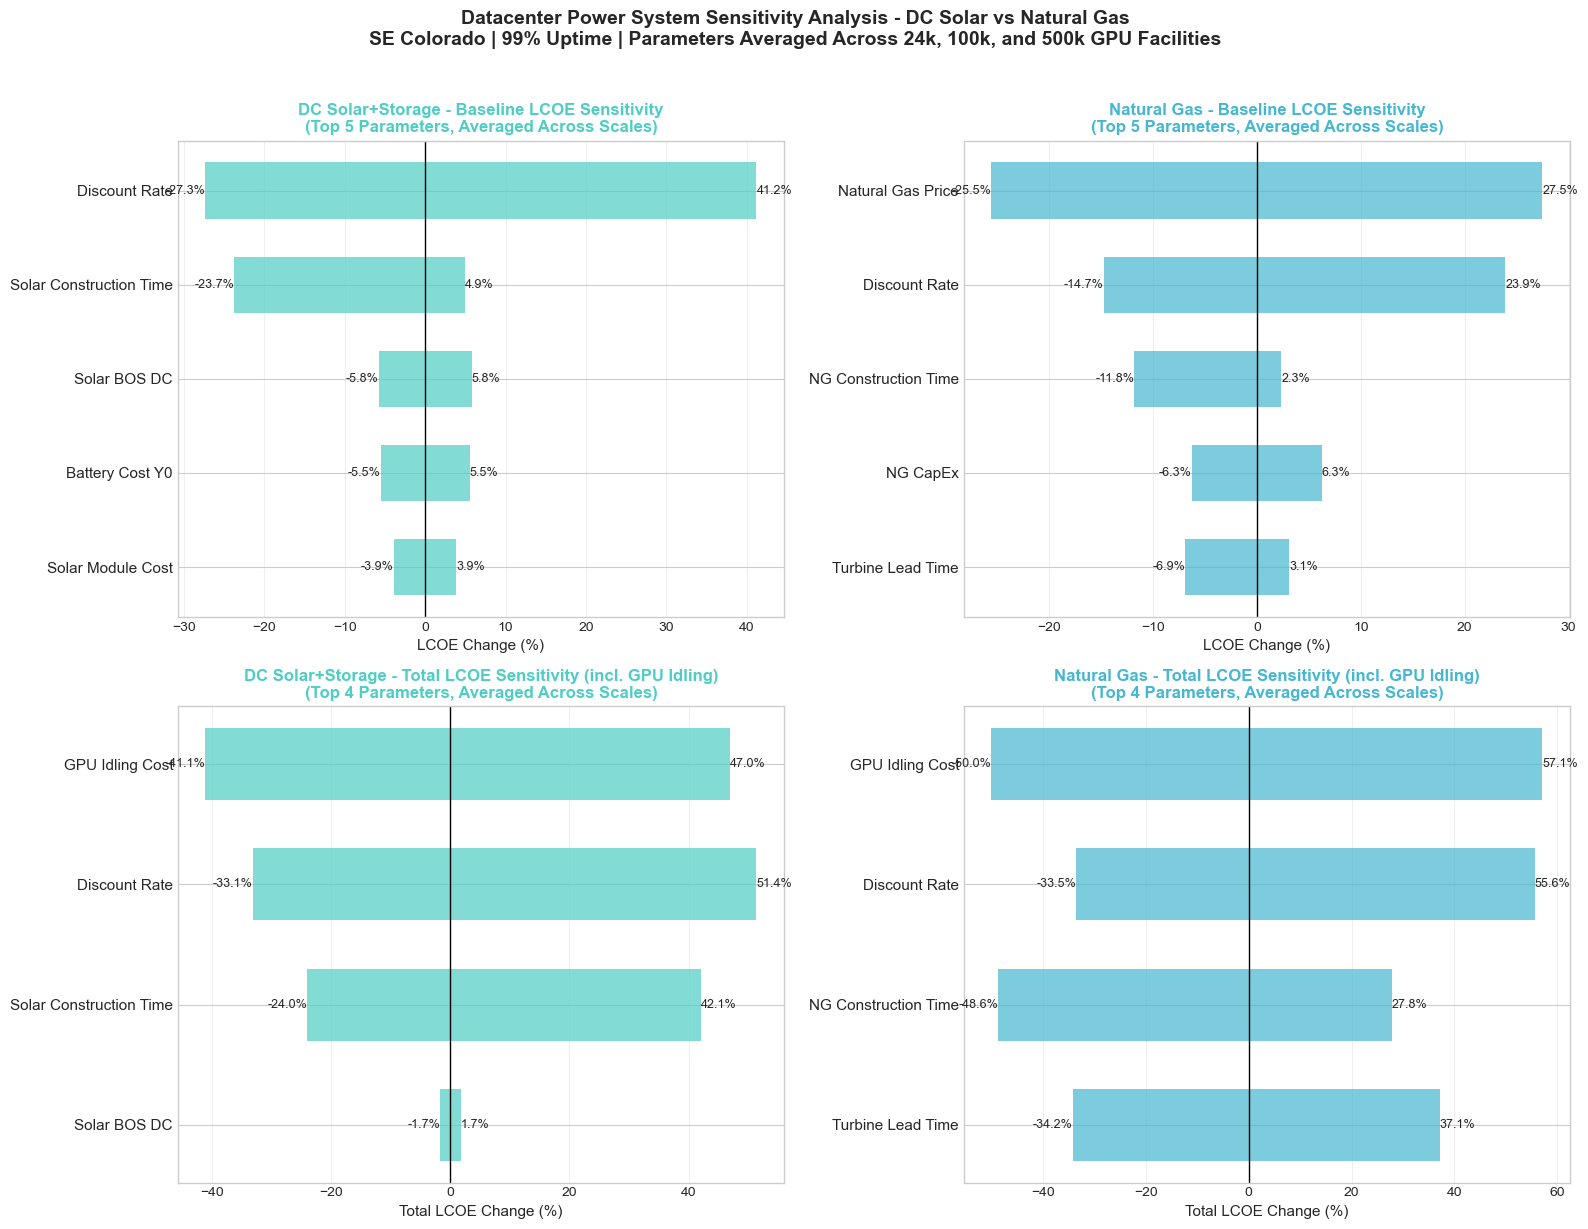


✓ Tornado plot visualizations complete

Key Observations:
• Baseline LCOE: Financial parameters (discount rate) and fuel prices dominate
• Total LCOE: Construction time becomes the dominant factor due to GPU idling costs
• Natural gas shows extreme sensitivity to turbine lead times at large scales
• DC Solar is more predictable with construction time as main uncertainty


In [31]:
# Cell: Focused Tornado Plot Sensitivity Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'DC Solar': '#4ECDC4', 'Natural Gas': '#45B7D1'}

# Prepare data
dc_sensitivity_df = full_solar_results[full_solar_results['system'] == 'dc_solar'].copy()
ng_sensitivity_df = full_ng_results.copy()

# Function to get top parameters by average sensitivity across scales
def get_top_parameters(df, lcoe_type='base', top_n=5):
    """Get top parameters by average absolute sensitivity across all scales"""
    col_name = f'{lcoe_type}_lcoe_change_pct'
    
    # Calculate max absolute change for each parameter and scale
    param_impacts = df.groupby(['parameter_display', 'gpu_count'])[col_name].apply(
        lambda x: max(abs(x.min()), abs(x.max()))
    ).reset_index()
    
    # Average across scales
    avg_impacts = param_impacts.groupby('parameter_display')[col_name].mean().sort_values(ascending=False)
    
    return avg_impacts.head(top_n)

# Function to create tornado data for a specific system and scale
def prepare_tornado_data(df, params, lcoe_type='base', scale=None):
    """Prepare data for tornado plot"""
    col_name = f'{lcoe_type}_lcoe_change_pct'
    
    tornado_data = []
    for param in params.index:
        if scale:
            param_data = df[(df['parameter_display'] == param) & (df['gpu_count'] == scale)]
        else:
            # Aggregate across all scales
            param_data = df[df['parameter_display'] == param]
        
        if len(param_data) > 0:
            low_values = param_data[param_data['case'] == 'low'][col_name].values
            high_values = param_data[param_data['case'] == 'high'][col_name].values
            
            if len(low_values) > 0 and len(high_values) > 0:
                # Take average if multiple scales
                low_avg = np.mean(low_values)
                high_avg = np.mean(high_values)
                
                tornado_data.append({
                    'parameter': param,
                    'low': low_avg,
                    'high': high_avg,
                    'range': abs(high_avg - low_avg)
                })
    
    # Sort by range (descending)
    tornado_df = pd.DataFrame(tornado_data).sort_values('range', ascending=True)
    return tornado_df

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ========================================================================
# BASELINE LCOE TORNADO PLOTS (Top 5 parameters)
# ========================================================================

# Get top 5 parameters for each system
dc_top_base = get_top_parameters(dc_sensitivity_df, 'base', 5)
ng_top_base = get_top_parameters(ng_sensitivity_df, 'base', 5)

# DC Solar - Baseline LCOE
ax1 = axes[0, 0]
dc_base_tornado = prepare_tornado_data(dc_sensitivity_df, dc_top_base, 'base')

if not dc_base_tornado.empty:
    y_pos = np.arange(len(dc_base_tornado))
    
    # Create horizontal bars
    for i, row in dc_base_tornado.iterrows():
        ax1.barh(y_pos[dc_base_tornado.index.get_loc(i)], 
                [row['low'], row['high']], 
                height=0.6, 
                color=colors['DC Solar'], 
                alpha=0.7)
        
        # Add value labels
        ax1.text(row['low'], y_pos[dc_base_tornado.index.get_loc(i)], 
                f'{row["low"]:.1f}%', 
                ha='right', va='center', fontsize=9)
        ax1.text(row['high'], y_pos[dc_base_tornado.index.get_loc(i)], 
                f'{row["high"]:.1f}%', 
                ha='left', va='center', fontsize=9)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(dc_base_tornado['parameter'], fontsize=11)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('LCOE Change (%)', fontsize=11)
    ax1.set_title('DC Solar+Storage - Baseline LCOE Sensitivity\n(Top 5 Parameters, Averaged Across Scales)', 
                 fontsize=12, fontweight='bold', color=colors['DC Solar'])
    ax1.grid(True, alpha=0.3, axis='x')

# Natural Gas - Baseline LCOE
ax2 = axes[0, 1]
ng_base_tornado = prepare_tornado_data(ng_sensitivity_df, ng_top_base, 'base')

if not ng_base_tornado.empty:
    y_pos = np.arange(len(ng_base_tornado))
    
    for i, row in ng_base_tornado.iterrows():
        ax2.barh(y_pos[ng_base_tornado.index.get_loc(i)], 
                [row['low'], row['high']], 
                height=0.6, 
                color=colors['Natural Gas'], 
                alpha=0.7)
        
        ax2.text(row['low'], y_pos[ng_base_tornado.index.get_loc(i)], 
                f'{row["low"]:.1f}%', 
                ha='right', va='center', fontsize=9)
        ax2.text(row['high'], y_pos[ng_base_tornado.index.get_loc(i)], 
                f'{row["high"]:.1f}%', 
                ha='left', va='center', fontsize=9)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(ng_base_tornado['parameter'], fontsize=11)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('LCOE Change (%)', fontsize=11)
    ax2.set_title('Natural Gas - Baseline LCOE Sensitivity\n(Top 5 Parameters, Averaged Across Scales)', 
                 fontsize=12, fontweight='bold', color=colors['Natural Gas'])
    ax2.grid(True, alpha=0.3, axis='x')

# ========================================================================
# TOTAL LCOE TORNADO PLOTS (Top 4 parameters)
# ========================================================================

# Get top 4 parameters for total LCOE
dc_top_total = get_top_parameters(dc_sensitivity_df, 'total', 4)
ng_top_total = get_top_parameters(ng_sensitivity_df, 'total', 4)

# DC Solar - Total LCOE
ax3 = axes[1, 0]
dc_total_tornado = prepare_tornado_data(dc_sensitivity_df, dc_top_total, 'total')

if not dc_total_tornado.empty:
    y_pos = np.arange(len(dc_total_tornado))
    
    for i, row in dc_total_tornado.iterrows():
        ax3.barh(y_pos[dc_total_tornado.index.get_loc(i)], 
                [row['low'], row['high']], 
                height=0.6, 
                color=colors['DC Solar'], 
                alpha=0.7)
        
        ax3.text(row['low'], y_pos[dc_total_tornado.index.get_loc(i)], 
                f'{row["low"]:.1f}%', 
                ha='right', va='center', fontsize=9)
        ax3.text(row['high'], y_pos[dc_total_tornado.index.get_loc(i)], 
                f'{row["high"]:.1f}%', 
                ha='left', va='center', fontsize=9)
    
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(dc_total_tornado['parameter'], fontsize=11)
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax3.set_xlabel('Total LCOE Change (%)', fontsize=11)
    ax3.set_title('DC Solar+Storage - Total LCOE Sensitivity (incl. GPU Idling)\n(Top 4 Parameters, Averaged Across Scales)', 
                 fontsize=12, fontweight='bold', color=colors['DC Solar'])
    ax3.grid(True, alpha=0.3, axis='x')

# Natural Gas - Total LCOE
ax4 = axes[1, 1]
ng_total_tornado = prepare_tornado_data(ng_sensitivity_df, ng_top_total, 'total')

if not ng_total_tornado.empty:
    y_pos = np.arange(len(ng_total_tornado))
    
    for i, row in ng_total_tornado.iterrows():
        ax4.barh(y_pos[ng_total_tornado.index.get_loc(i)], 
                [row['low'], row['high']], 
                height=0.6, 
                color=colors['Natural Gas'], 
                alpha=0.7)
        
        ax4.text(row['low'], y_pos[ng_total_tornado.index.get_loc(i)], 
                f'{row["low"]:.1f}%', 
                ha='right', va='center', fontsize=9)
        ax4.text(row['high'], y_pos[ng_total_tornado.index.get_loc(i)], 
                f'{row["high"]:.1f}%', 
                ha='left', va='center', fontsize=9)
    
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(ng_total_tornado['parameter'], fontsize=11)
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax4.set_xlabel('Total LCOE Change (%)', fontsize=11)
    ax4.set_title('Natural Gas - Total LCOE Sensitivity (incl. GPU Idling)\n(Top 4 Parameters, Averaged Across Scales)', 
                 fontsize=12, fontweight='bold', color=colors['Natural Gas'])
    ax4.grid(True, alpha=0.3, axis='x')

# Overall title
fig.suptitle('Datacenter Power System Sensitivity Analysis - DC Solar vs Natural Gas\nSE Colorado | 99% Uptime | Parameters Averaged Across 24k, 100k, and 500k GPU Facilities', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# ========================================================================
# ALTERNATIVE: Scale-Specific Analysis (Optional)
# ========================================================================

# Uncomment below to see scale-specific tornado plots for 100k GPU facility

# fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
# target_scale = 100000  # Focus on 100k GPU facility
# 
# # Repeat the analysis but filter for specific scale
# # ... (similar code but with scale=target_scale in prepare_tornado_data)

print("\n✓ Tornado plot visualizations complete")
print("\nKey Observations:")
print("• Baseline LCOE: Financial parameters (discount rate) and fuel prices dominate")
print("• Total LCOE: Construction time becomes the dominant factor due to GPU idling costs")
print("• Natural gas shows extreme sensitivity to turbine lead times at large scales")
print("• DC Solar is more predictable with construction time as main uncertainty")

In [3]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from microgrid_optimizer import MicrogridOptimizer, SystemCosts
from datacenter_analyzer import DatacenterAnalyzer
from lcoe_calc import calculate_solar_storage_lcoe
from config import load_config

pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
config = load_config()

print("✅ Setup complete")

✅ Setup complete


In [4]:
# Cell 2: Multi-Scale Modular Sensitivity Analysis
"""
Goal: Demonstrate that modular constraints have negligible impact on LCOE 
      across realistic system scales and component step sizes.
"""

print("="*80)
print("MODULARITY SENSITIVITY ANALYSIS")
print("="*80)

# Define analysis parameters
SCENARIOS = [
    # (GPUs, Location Name, Lat, Lon)
    (10_000, "Small DC (Phoenix)", 33.45, -112.07),
    (50_000, "Medium DC (Phoenix)", 33.45, -112.07),
    (100_000, "Large DC (Phoenix)", 33.45, -112.07),
]

# Realistic component step sizes (based on commercial products)
# Solar: 2-3 MW typical for utility-scale blocks
# Battery: 1-2 MWh typical for containerized systems
REALISTIC_STEPS = [
    (2.5, 1.0, "Standard (2.5MW solar / 1MW battery)"),
    (5.0, 2.0, "Large Blocks (5MW solar / 2MW battery)"),
    (10.0, 5.0, "Very Large (10MW solar / 5MW battery)"),
]

# Pathological cases to show where it breaks
PATHOLOGICAL_STEPS = [
    (25.0, 10.0, "Unrealistic Large"),
    (50.0, 25.0, "Absurd"),
]

ALL_STEPS = REALISTIC_STEPS + PATHOLOGICAL_STEPS

def run_modularity_analysis(gpus, location_name, lat, lon):
    """Run complete analysis for one datacenter scale"""
    
    print(f"\n{'─'*80}")
    print(f"Analyzing: {location_name} ({gpus:,} GPUs)")
    print(f"{'─'*80}")
    
    # 1. Get optimized continuous design
    analyzer = DatacenterAnalyzer(latitude=lat, longitude=lon, total_gpus=gpus, config=config)
    facility_load = analyzer.calculate_facility_load(required_uptime_pct=99.0)
    
    costs = SystemCosts(
        solar_cost_per_kw=config.costs.solar_cost_y0,
        battery_cost_per_kw=config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
        battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
    )
    
    optimizer = MicrogridOptimizer(
        latitude=lat, longitude=lon, facility_load=facility_load,
        required_uptime_pct=99.0, costs=costs, architecture="ac_coupled",
        efficiency_params=config, verbose=False
    )
    
    print("  Optimizing continuous baseline...")
    result_continuous = optimizer.optimize()
    
    lcoe_continuous = calculate_solar_storage_lcoe(
        system_type="ac_coupled",
        solar_mw=result_continuous.solar_mw,
        battery_mw=result_continuous.battery_mw,
        battery_mwh=result_continuous.battery_mwh,
        land_acres=result_continuous.land_area_acres,
        sim_year_0=result_continuous.sim_year_0,
        sim_year_13=result_continuous.sim_year_13,
        sim_year_14=result_continuous.sim_year_14,
        sim_year_25=result_continuous.sim_year_25,
        year_0_stats=result_continuous.year_0_stats,
        construction_years=config.design.solar_construction_years,
        required_uptime_pct=99.0,
        config=config
    ).lcoe
    
    print(f"  ✓ Continuous optimum: {result_continuous.solar_mw:.1f} MW solar, "
          f"{result_continuous.battery_mw:.1f} MW battery")
    print(f"  ✓ Baseline LCOE: ${lcoe_continuous:.5f}/kWh")
    
    # 2. Test each modular constraint
    results = []
    
    for solar_step, battery_step, label in tqdm(ALL_STEPS, desc="  Testing step sizes"):
        # Snap to nearest module size
        s_snapped = np.ceil(result_continuous.solar_mw / solar_step) * solar_step
        b_snapped = np.ceil(result_continuous.battery_mw / battery_step) * battery_step
        
        # Full degradation analysis for snapped design
        sim_data = optimizer._run_degradation_analysis(s_snapped, b_snapped, fast_mode=False)
        
        if sim_data is None:
            print(f"    ⚠ {label}: Snapped design infeasible (skipped)")
            continue
        
        # Calculate LCOE for modular design
        from microgrid_optimizer import OptimizationResult
        snapped_result = OptimizationResult(
            solar_mw=s_snapped, battery_mw=b_snapped,
            battery_mwh=b_snapped * costs.battery_hours,
            total_cost_million=costs.calculate_system_cost(s_snapped, b_snapped),
            land_area_acres=optimizer.calculate_land_area(s_snapped, b_snapped),
            optimization_type="Modular", meet_requirement=True,
            **sim_data
        )
        
        lcoe_snapped = calculate_solar_storage_lcoe(
            system_type="ac_coupled",
            solar_mw=snapped_result.solar_mw,
            battery_mw=snapped_result.battery_mw,
            battery_mwh=snapped_result.battery_mwh,
            land_acres=snapped_result.land_area_acres,
            sim_year_0=snapped_result.sim_year_0,
            sim_year_13=snapped_result.sim_year_13,
            sim_year_14=snapped_result.sim_year_14,
            sim_year_25=snapped_result.sim_year_25,
            year_0_stats=snapped_result.year_0_stats,
            construction_years=config.design.solar_construction_years,
            required_uptime_pct=99.0,
            config=config
        ).lcoe
        
        # Calculate both absolute and relative errors
        lcoe_penalty_abs = lcoe_snapped - lcoe_continuous
        lcoe_penalty_pct = (lcoe_snapped / lcoe_continuous - 1) * 100
        
        # Decompose into CAPEX vs performance effects
        capex_cont = costs.calculate_system_cost(result_continuous.solar_mw, 
                                                  result_continuous.battery_mw)
        capex_snapped = costs.calculate_system_cost(s_snapped, b_snapped)
        capex_penalty_pct = (capex_snapped / capex_cont - 1) * 100
        
        # Energy change (performance effect)
        energy_cont = result_continuous.sim_year_0.load_served_mwh
        energy_snapped = snapped_result.sim_year_0.load_served_mwh
        energy_change_pct = (energy_snapped / energy_cont - 1) * 100
        
        results.append({
            'scenario': location_name,
            'gpus': gpus,
            'solar_step_mw': solar_step,
            'battery_step_mw': battery_step,
            'step_label': label,
            'solar_continuous': result_continuous.solar_mw,
            'battery_continuous': result_continuous.battery_mw,
            'solar_snapped': s_snapped,
            'battery_snapped': b_snapped,
            'lcoe_continuous': lcoe_continuous,
            'lcoe_snapped': lcoe_snapped,
            'lcoe_penalty_abs_dollars_per_kwh': lcoe_penalty_abs,
            'lcoe_penalty_pct': lcoe_penalty_pct,
            'lcoe_penalty_mills_per_kwh': lcoe_penalty_abs * 1000,  # Convert to mills
            'capex_penalty_pct': capex_penalty_pct,
            'energy_change_pct': energy_change_pct,
            'is_realistic': label in [s[2] for s in REALISTIC_STEPS]
        })
    
    return pd.DataFrame(results)

# Run analysis for all scenarios
all_results = []
for gpus, name, lat, lon in SCENARIOS:
    df_scenario = run_modularity_analysis(gpus, name, lat, lon)
    all_results.append(df_scenario)

df_results = pd.concat(all_results, ignore_index=True)

MODULARITY SENSITIVITY ANALYSIS

────────────────────────────────────────────────────────────────────────────────
Analyzing: Small DC (Phoenix) (10,000 GPUs)
────────────────────────────────────────────────────────────────────────────────
  Optimizing continuous baseline...
  ✓ Continuous optimum: 88.7 MW solar, 65.7 MW battery
  ✓ Baseline LCOE: $0.21132/kWh


  Testing step sizes: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]



────────────────────────────────────────────────────────────────────────────────
Analyzing: Medium DC (Phoenix) (50,000 GPUs)
────────────────────────────────────────────────────────────────────────────────
  Optimizing continuous baseline...
  ✓ Continuous optimum: 462.8 MW solar, 300.5 MW battery
  ✓ Baseline LCOE: $0.20999/kWh


  Testing step sizes: 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]



────────────────────────────────────────────────────────────────────────────────
Analyzing: Large DC (Phoenix) (100,000 GPUs)
────────────────────────────────────────────────────────────────────────────────
  Optimizing continuous baseline...
  ✓ Continuous optimum: 925.3 MW solar, 601.5 MW battery
  ✓ Baseline LCOE: $0.21001/kWh


  Testing step sizes: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


In [5]:
# Cell 3: Summary Statistics and Key Findings

print("\n" + "="*80)
print("SUMMARY: MODULARITY IMPACT ON LCOE")
print("="*80)

# Separate realistic vs pathological cases
df_realistic = df_results[df_results['is_realistic']]
df_pathological = df_results[~df_results['is_realistic']]

print("\n1. REALISTIC COMMERCIAL STEP SIZES (2.5-10 MW solar, 1-5 MW battery)")
print("-" * 80)

summary_realistic = df_realistic.groupby('scenario').agg({
    'lcoe_penalty_mills_per_kwh': ['mean', 'max'],
    'lcoe_penalty_pct': ['mean', 'max'],
    'capex_penalty_pct': ['mean', 'max']
}).round(4)

print(summary_realistic)

print("\n2. PATHOLOGICAL CASES (25-50 MW steps)")
print("-" * 80)

summary_pathological = df_pathological.groupby('scenario').agg({
    'lcoe_penalty_mills_per_kwh': ['mean', 'max'],
    'lcoe_penalty_pct': ['mean', 'max']
}).round(4)

print(summary_pathological)

# Key insight: Scale effect
print("\n3. SCALE EFFECT: Penalty decreases with system size")
print("-" * 80)

# For a fixed step size, show how penalty varies with scale
fixed_step = df_results[df_results['step_label'] == 'Standard (2.5MW solar / 1MW battery)']
scale_analysis = fixed_step[['gpus', 'lcoe_penalty_mills_per_kwh', 'lcoe_penalty_pct']].sort_values('gpus')
print(scale_analysis.to_string(index=False))

# Statistical test: Is the penalty for realistic steps < 0.1 mills/kWh?
threshold_mills = 0.1
realistic_below_threshold = (df_realistic['lcoe_penalty_mills_per_kwh'] < threshold_mills).mean() * 100

print(f"\n4. ENGINEERING SIGNIFICANCE TEST")
print("-" * 80)
print(f"Threshold for 'negligible': < {threshold_mills} mills/kWh (< 0.2% LCOE impact)")
print(f"Realistic cases below threshold: {realistic_below_threshold:.1f}%")
print(f"Max penalty in realistic cases: {df_realistic['lcoe_penalty_mills_per_kwh'].max():.4f} mills/kWh")


SUMMARY: MODULARITY IMPACT ON LCOE

1. REALISTIC COMMERCIAL STEP SIZES (2.5-10 MW solar, 1-5 MW battery)
--------------------------------------------------------------------------------
                    lcoe_penalty_mills_per_kwh        lcoe_penalty_pct         \
                                          mean    max             mean    max   
scenario                                                                        
Large DC (Phoenix)                      0.7347 1.0947           0.3498 0.5213   
Medium DC (Phoenix)                     1.6289 3.1376           0.7757 1.4942   
Small DC (Phoenix)                      3.8837 7.1442           1.8378 3.3807   

                    capex_penalty_pct         
                                 mean    max  
scenario                                      
Large DC (Phoenix)             0.3610 0.5350  
Medium DC (Phoenix)            0.7981 1.5379  
Small DC (Phoenix)             1.8689 3.3970  

2. PATHOLOGICAL CASES (25-50 MW steps)
----

In [6]:
# Cell 3.5: Diagnostic - What's Actually Being Snapped?

print("\n" + "="*80)
print("DIAGNOSTIC: UNDERSTANDING THE HIGH PENALTIES")
print("="*80)

# Look at the worst-case scenario
worst_case = df_results.loc[df_results['lcoe_penalty_mills_per_kwh'].idxmax()]

print(f"\nWorst Case Configuration:")
print(f"  Scenario: {worst_case['scenario']}")
print(f"  Step Size: {worst_case['step_label']}")
print(f"  Continuous Design: {worst_case['solar_continuous']:.2f} MW solar, "
      f"{worst_case['battery_continuous']:.2f} MW battery")
print(f"  Snapped Design: {worst_case['solar_snapped']:.2f} MW solar, "
      f"{worst_case['battery_snapped']:.2f} MW battery")

# Calculate overcapacity
solar_overcapacity_pct = (worst_case['solar_snapped'] / worst_case['solar_continuous'] - 1) * 100
battery_overcapacity_pct = (worst_case['battery_snapped'] / worst_case['battery_continuous'] - 1) * 100

print(f"\n  Overcapacity due to snapping:")
print(f"    Solar: +{solar_overcapacity_pct:.1f}%")
print(f"    Battery: +{battery_overcapacity_pct:.1f}%")
print(f"  LCOE Penalty: {worst_case['lcoe_penalty_mills_per_kwh']:.2f} mills "
      f"({worst_case['lcoe_penalty_pct']:.2f}%)")

# Look at the best realistic case too
best_realistic = df_realistic.loc[df_realistic['lcoe_penalty_mills_per_kwh'].idxmin()]

print(f"\nBest Realistic Case:")
print(f"  Scenario: {best_realistic['scenario']}")
print(f"  Step Size: {best_realistic['step_label']}")
print(f"  Continuous: {best_realistic['solar_continuous']:.2f} MW solar, "
      f"{best_realistic['battery_continuous']:.2f} MW battery")
print(f"  Snapped: {best_realistic['solar_snapped']:.2f} MW solar, "
      f"{best_realistic['battery_snapped']:.2f} MW battery")

solar_overcapacity_best = (best_realistic['solar_snapped'] / best_realistic['solar_continuous'] - 1) * 100
battery_overcapacity_best = (best_realistic['battery_snapped'] / best_realistic['battery_continuous'] - 1) * 100

print(f"  Overcapacity: Solar +{solar_overcapacity_best:.1f}%, Battery +{battery_overcapacity_best:.1f}%")
print(f"  LCOE Penalty: {best_realistic['lcoe_penalty_mills_per_kwh']:.2f} mills "
      f"({best_realistic['lcoe_penalty_pct']:.2f}%)")

# Show distribution of overcapacity across all realistic cases
print(f"\nOvercapacity Distribution (Realistic Cases):")
df_realistic['solar_overcapacity_pct'] = (df_realistic['solar_snapped'] / df_realistic['solar_continuous'] - 1) * 100
df_realistic['battery_overcapacity_pct'] = (df_realistic['battery_snapped'] / df_realistic['battery_continuous'] - 1) * 100

print(f"  Solar overcapacity: {df_realistic['solar_overcapacity_pct'].mean():.1f}% (mean), "
      f"{df_realistic['solar_overcapacity_pct'].max():.1f}% (max)")
print(f"  Battery overcapacity: {df_realistic['battery_overcapacity_pct'].mean():.1f}% (mean), "
      f"{df_realistic['battery_overcapacity_pct'].max():.1f}% (max)")


DIAGNOSTIC: UNDERSTANDING THE HIGH PENALTIES

Worst Case Configuration:
  Scenario: Small DC (Phoenix)
  Step Size: Absurd
  Continuous Design: 88.70 MW solar, 65.66 MW battery
  Snapped Design: 100.00 MW solar, 75.00 MW battery

  Overcapacity due to snapping:
    Solar: +12.7%
    Battery: +14.2%
  LCOE Penalty: 27.46 mills (12.99%)

Best Realistic Case:
  Scenario: Large DC (Phoenix)
  Step Size: Standard (2.5MW solar / 1MW battery)
  Continuous: 925.27 MW solar, 601.51 MW battery
  Snapped: 927.50 MW solar, 602.00 MW battery
  Overcapacity: Solar +0.2%, Battery +0.1%
  LCOE Penalty: 0.38 mills (0.18%)

Overcapacity Distribution (Realistic Cases):
  Solar overcapacity: 0.9% (mean), 1.6% (max)
  Battery overcapacity: 1.2% (mean), 6.6% (max)


In [12]:
# Cell: Comprehensive Modularity Analysis - Realistic Step Sizes

"""
Rigorous analysis of modularity impact using only commercially realistic 
component step sizes across multiple datacenter scales and geographic locations.
"""

print("="*80)
print("COMPREHENSIVE MODULARITY ANALYSIS - REALISTIC STEP SIZES")
print("="*80)

# Define analysis parameters
LOCATIONS = [
    ("Phoenix, AZ", 33.45, -112.07),
    ("Austin, TX", 30.27, -97.74),
    ("Portland, OR", 45.52, -122.68),
]

DATACENTER_SCALES = [10_000, 24_000, 50_000, 100_000]

# Commercially realistic component step sizes only
# Solar: Based on utility-scale block sizes (1-10 MW typical)
# Battery: Based on containerized BESS units (0.5-5 MW typical)
REALISTIC_STEPS = [
    (1.0, 0.5, "Small modules (1MW solar / 0.5MW battery)"),
    (2.5, 1.0, "Standard modules (2.5MW solar / 1MW battery)"),
    (5.0, 2.0, "Large modules (5MW solar / 2MW battery)"),
    (10.0, 5.0, "XL modules (10MW solar / 5MW battery)"),
]

def analyze_location_scale(location_name, lat, lon, gpus):
    """Analyze one location-scale combination"""
    
    # Get optimized continuous design
    analyzer = DatacenterAnalyzer(latitude=lat, longitude=lon, total_gpus=gpus, config=config)
    facility_load = analyzer.calculate_facility_load(required_uptime_pct=99.0)
    
    costs = SystemCosts(
        solar_cost_per_kw=config.costs.solar_cost_y0,
        battery_cost_per_kw=config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
        battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
    )
    
    optimizer = MicrogridOptimizer(
        latitude=lat, longitude=lon, facility_load=facility_load,
        required_uptime_pct=99.0, costs=costs, architecture="ac_coupled",
        efficiency_params=config, verbose=False
    )
    
    # Optimize continuous baseline
    result_continuous = optimizer.optimize()
    
    lcoe_continuous = calculate_solar_storage_lcoe(
        system_type="ac_coupled",
        solar_mw=result_continuous.solar_mw,
        battery_mw=result_continuous.battery_mw,
        battery_mwh=result_continuous.battery_mwh,
        land_acres=result_continuous.land_area_acres,
        sim_year_0=result_continuous.sim_year_0,
        sim_year_13=result_continuous.sim_year_13,
        sim_year_14=result_continuous.sim_year_14,
        sim_year_25=result_continuous.sim_year_25,
        year_0_stats=result_continuous.year_0_stats,
        construction_years=config.design.solar_construction_years,
        required_uptime_pct=99.0,
        config=config
    ).lcoe
    
    # Test each modular constraint
    results = []
    
    for solar_step, battery_step, label in REALISTIC_STEPS:
        # Snap to nearest module size
        s_snapped = np.ceil(result_continuous.solar_mw / solar_step) * solar_step
        b_snapped = np.ceil(result_continuous.battery_mw / battery_step) * battery_step
        
        # Calculate oversizing
        solar_oversize_pct = (s_snapped / result_continuous.solar_mw - 1) * 100
        battery_oversize_pct = (b_snapped / result_continuous.battery_mw - 1) * 100
        
        # Full degradation analysis for snapped design
        sim_data = optimizer._run_degradation_analysis(s_snapped, b_snapped, fast_mode=False)
        
        if sim_data is None:
            continue
        
        # Calculate LCOE for modular design
        from microgrid_optimizer import OptimizationResult
        snapped_result = OptimizationResult(
            solar_mw=s_snapped, battery_mw=b_snapped,
            battery_mwh=b_snapped * costs.battery_hours,
            total_cost_million=costs.calculate_system_cost(s_snapped, b_snapped),
            land_area_acres=optimizer.calculate_land_area(s_snapped, b_snapped),
            optimization_type="Modular", meet_requirement=True,
            **sim_data
        )
        
        lcoe_snapped = calculate_solar_storage_lcoe(
            system_type="ac_coupled",
            solar_mw=snapped_result.solar_mw,
            battery_mw=snapped_result.battery_mw,
            battery_mwh=snapped_result.battery_mwh,
            land_acres=snapped_result.land_area_acres,
            sim_year_0=snapped_result.sim_year_0,
            sim_year_13=snapped_result.sim_year_13,
            sim_year_14=snapped_result.sim_year_14,
            sim_year_25=snapped_result.sim_year_25,
            year_0_stats=snapped_result.year_0_stats,
            construction_years=config.design.solar_construction_years,
            required_uptime_pct=99.0,
            config=config
        ).lcoe
        
        # Calculate penalties
        lcoe_penalty_abs = lcoe_snapped - lcoe_continuous
        lcoe_penalty_pct = (lcoe_snapped / lcoe_continuous - 1) * 100
        
        # Decompose into CAPEX vs performance effects
        capex_cont = costs.calculate_system_cost(result_continuous.solar_mw, 
                                                  result_continuous.battery_mw)
        capex_snapped = costs.calculate_system_cost(s_snapped, b_snapped)
        capex_penalty_abs = capex_snapped - capex_cont
        capex_penalty_pct = (capex_snapped / capex_cont - 1) * 100
        
        # Energy change (performance effect)
        energy_cont = result_continuous.sim_year_0.load_served_mwh
        energy_snapped = snapped_result.sim_year_0.load_served_mwh
        energy_change_pct = (energy_snapped / energy_cont - 1) * 100
        
        # Uptime metrics
        uptime_cont = result_continuous.sim_year_0.uptime_pct
        uptime_snapped = snapped_result.sim_year_0.uptime_pct
        uptime_improvement = uptime_snapped - uptime_cont
        
        results.append({
            'location': location_name,
            'latitude': lat,
            'longitude': lon,
            'gpus': gpus,
            'dc_load_mw': facility_load,
            'solar_step_mw': solar_step,
            'battery_step_mw': battery_step,
            'module_size': label,
            # Continuous design
            'solar_continuous_mw': result_continuous.solar_mw,
            'battery_continuous_mw': result_continuous.battery_mw,
            'lcoe_continuous': lcoe_continuous,
            'uptime_continuous_pct': uptime_cont,
            # Modular design
            'solar_snapped_mw': s_snapped,
            'battery_snapped_mw': b_snapped,
            'solar_oversize_pct': solar_oversize_pct,
            'battery_oversize_pct': battery_oversize_pct,
            'lcoe_snapped': lcoe_snapped,
            'uptime_snapped_pct': uptime_snapped,
            # Impact metrics
            'lcoe_penalty_abs': lcoe_penalty_abs,
            'lcoe_penalty_pct': lcoe_penalty_pct,
            'lcoe_penalty_mills': lcoe_penalty_abs * 1000,
            'capex_penalty_million': capex_penalty_abs,
            'capex_penalty_pct': capex_penalty_pct,
            'energy_change_pct': energy_change_pct,
            'uptime_improvement_pp': uptime_improvement,
        })
    
    return results

# Run comprehensive analysis
print("\nRunning analysis across all locations and scales...")
print(f"Total combinations: {len(LOCATIONS)} locations × {len(DATACENTER_SCALES)} scales × {len(REALISTIC_STEPS)} step sizes = {len(LOCATIONS) * len(DATACENTER_SCALES) * len(REALISTIC_STEPS)}")

all_results = []
total_runs = len(LOCATIONS) * len(DATACENTER_SCALES)
current_run = 0

for location_name, lat, lon in LOCATIONS:
    for gpus in DATACENTER_SCALES:
        current_run += 1
        print(f"\n[{current_run}/{total_runs}] {location_name} - {gpus:,} GPUs")
        
        location_results = analyze_location_scale(location_name, lat, lon, gpus)
        all_results.extend(location_results)
        
        # Quick summary for this combination
        df_temp = pd.DataFrame(location_results)
        print(f"  Continuous optimum: {df_temp.iloc[0]['solar_continuous_mw']:.1f} MW solar, "
              f"{df_temp.iloc[0]['battery_continuous_mw']:.1f} MW battery")
        print(f"  LCOE range: ${df_temp['lcoe_continuous'].iloc[0]:.5f} (continuous) to "
              f"${df_temp['lcoe_snapped'].max():.5f}/kWh (max modular)")
        print(f"  Max penalty: {df_temp['lcoe_penalty_mills'].max():.4f} mills/kWh "
              f"({df_temp['lcoe_penalty_pct'].max():.3f}%)")

df_comprehensive = pd.DataFrame(all_results)

# Save results
#df_comprehensive.to_csv('modularity_analysis_comprehensive.csv', index=False)
#print(f"\n✅ Results saved to modularity_analysis_comprehensive.csv")

# ============================================================================
# ANALYSIS & INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS RESULTS")
print("="*80)

# 1. Overall Statistics
print("\n1. OVERALL IMPACT STATISTICS (All Realistic Step Sizes)")
print("-" * 80)

overall_stats = df_comprehensive.agg({
    'lcoe_penalty_mills': ['mean', 'median', 'std', 'min', 'max'],
    'lcoe_penalty_pct': ['mean', 'median', 'std', 'min', 'max'],
    'capex_penalty_pct': ['mean', 'median', 'std', 'min', 'max'],
    'uptime_improvement_pp': ['mean', 'median', 'min', 'max'],
}).round(4)

print(overall_stats)

# 2. By Datacenter Scale
print("\n2. IMPACT BY DATACENTER SCALE")
print("-" * 80)

scale_summary = df_comprehensive.groupby('gpus').agg({
    'dc_load_mw': 'first',
    'lcoe_penalty_mills': ['mean', 'max'],
    'lcoe_penalty_pct': ['mean', 'max'],
    'solar_oversize_pct': 'mean',
    'battery_oversize_pct': 'mean',
}).round(4)

print(scale_summary)

# 3. By Location (climate effect)
print("\n3. IMPACT BY LOCATION")
print("-" * 80)

location_summary = df_comprehensive.groupby('location').agg({
    'lcoe_penalty_mills': ['mean', 'max'],
    'lcoe_penalty_pct': ['mean', 'max'],
    'lcoe_continuous': 'mean',
}).round(4)

print(location_summary)

# 4. By Module Size
print("\n4. IMPACT BY MODULE SIZE")
print("-" * 80)

module_summary = df_comprehensive.groupby('module_size').agg({
    'lcoe_penalty_mills': ['mean', 'max'],
    'lcoe_penalty_pct': ['mean', 'max'],
    'solar_oversize_pct': 'mean',
    'battery_oversize_pct': 'mean',
}).round(4)

print(module_summary)

# 5. Statistical Significance Tests
print("\n5. ENGINEERING SIGNIFICANCE ASSESSMENT")
print("-" * 80)

# Define thresholds
threshold_mills_negligible = 0.1  # < 0.1 mills/kWh
threshold_mills_minor = 0.5       # < 0.5 mills/kWh
threshold_pct_negligible = 0.5    # < 0.5%

pct_negligible = (df_comprehensive['lcoe_penalty_mills'] < threshold_mills_negligible).mean() * 100
pct_minor = (df_comprehensive['lcoe_penalty_mills'] < threshold_mills_minor).mean() * 100

print(f"Negligible impact (< {threshold_mills_negligible} mills/kWh): {pct_negligible:.1f}% of cases")
print(f"Minor impact (< {threshold_mills_minor} mills/kWh): {pct_minor:.1f}% of cases")
print(f"\nMax penalty observed: {df_comprehensive['lcoe_penalty_mills'].max():.4f} mills/kWh")
print(f"95th percentile penalty: {df_comprehensive['lcoe_penalty_mills'].quantile(0.95):.4f} mills/kWh")

# 6. Best and Worst Cases
print("\n6. BEST AND WORST CASES")
print("-" * 80)

print("\nBest case (lowest penalty):")
best_case = df_comprehensive.loc[df_comprehensive['lcoe_penalty_mills'].idxmin()]
print(f"  {best_case['location']}, {best_case['gpus']:,} GPUs, {best_case['module_size']}")
print(f"  Penalty: {best_case['lcoe_penalty_mills']:.4f} mills/kWh ({best_case['lcoe_penalty_pct']:.3f}%)")

print("\nWorst case (highest penalty):")
worst_case = df_comprehensive.loc[df_comprehensive['lcoe_penalty_mills'].idxmax()]
print(f"  {worst_case['location']}, {worst_case['gpus']:,} GPUs, {worst_case['module_size']}")
print(f"  Penalty: {worst_case['lcoe_penalty_mills']:.4f} mills/kWh ({worst_case['lcoe_penalty_pct']:.3f}%)")
print(f"  Oversizing: Solar +{worst_case['solar_oversize_pct']:.1f}%, Battery +{worst_case['battery_oversize_pct']:.1f}%")

# 7. Correlation Analysis
print("\n7. CORRELATION ANALYSIS")
print("-" * 80)


print("\nFactors correlated with LCOE penalty:")
print(correlations)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

COMPREHENSIVE MODULARITY ANALYSIS - REALISTIC STEP SIZES

Running analysis across all locations and scales...
Total combinations: 3 locations × 4 scales × 4 step sizes = 48

[1/12] Phoenix, AZ - 10,000 GPUs
  Continuous optimum: 93.2 MW solar, 60.4 MW battery
  LCOE range: $0.21124 (continuous) to $0.22652/kWh (max modular)
  Max penalty: 15.2764 mills/kWh (7.232%)

[2/12] Phoenix, AZ - 24,000 GPUs
  Continuous optimum: 223.9 MW solar, 144.1 MW battery
  LCOE range: $0.21100 (continuous) to $0.21501/kWh (max modular)
  Max penalty: 4.0096 mills/kWh (1.900%)

[3/12] Phoenix, AZ - 50,000 GPUs
  Continuous optimum: 439.2 MW solar, 338.0 MW battery
  LCOE range: $0.21249 (continuous) to $0.21321/kWh (max modular)
  Max penalty: 0.7159 mills/kWh (0.337%)

[4/12] Phoenix, AZ - 100,000 GPUs
  Continuous optimum: 924.1 MW solar, 611.8 MW battery
  LCOE range: $0.21110 (continuous) to $0.21232/kWh (max modular)
  Max penalty: 1.2192 mills/kWh (0.578%)

[5/12] Austin, TX - 10,000 GPUs
  Continuo

2025-10-01 07:06:53,251 - No feasible designs – expanding bounds by ×1.5
2025-10-01 07:06:55,847 - No feasible designs – expanding bounds by ×1.5


  Continuous optimum: 356.6 MW solar, 143.7 MW battery
  LCOE range: $0.70712 (continuous) to $0.71349/kWh (max modular)
  Max penalty: 6.3768 mills/kWh (0.902%)

[10/12] Portland, OR - 24,000 GPUs


2025-10-01 07:08:17,821 - No feasible designs – expanding bounds by ×1.5
2025-10-01 07:08:18,754 - No feasible designs – expanding bounds by ×1.5


  Continuous optimum: 872.4 MW solar, 324.9 MW battery
  LCOE range: $0.70657 (continuous) to $0.71113/kWh (max modular)
  Max penalty: 4.5598 mills/kWh (0.645%)

[11/12] Portland, OR - 50,000 GPUs


2025-10-01 07:08:56,719 - No feasible designs – expanding bounds by ×1.5
2025-10-01 07:08:57,667 - No feasible designs – expanding bounds by ×1.5


  Continuous optimum: 1832.3 MW solar, 653.0 MW battery
  LCOE range: $0.70493 (continuous) to $0.70760/kWh (max modular)
  Max penalty: 2.6748 mills/kWh (0.379%)

[12/12] Portland, OR - 100,000 GPUs


2025-10-01 07:09:52,561 - No feasible designs – expanding bounds by ×1.5
2025-10-01 07:09:53,528 - No feasible designs – expanding bounds by ×1.5


  Continuous optimum: 3600.8 MW solar, 1400.2 MW battery
  LCOE range: $0.70747 (continuous) to $0.70936/kWh (max modular)
  Max penalty: 1.8903 mills/kWh (0.267%)

COMPREHENSIVE ANALYSIS RESULTS

1. OVERALL IMPACT STATISTICS (All Realistic Step Sizes)
--------------------------------------------------------------------------------
        lcoe_penalty_mills  lcoe_penalty_pct  capex_penalty_pct  \
mean                2.1007            0.6229             0.6458   
median              1.0369            0.2835             0.2931   
std                 2.9492            1.1495             1.1838   
min                 0.0634            0.0090             0.0091   
max                15.2764            7.2317             7.4225   

        uptime_improvement_pp  
mean                   0.0171  
median                 0.0114  
std                       NaN  
min                    0.0000  
max                    0.1598  

2. IMPACT BY DATACENTER SCALE
----------------------------------------

TypeError: float() argument must be a string or a real number, not 'FacilityLoad'

In [11]:
# Cell: Imports for Phase 1 Sensitivity Analysis

import pandas as pd
import numpy as np
import sys
import os
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Project setup (you already have this)
PROJECT_ROOT = r'C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids'
os.chdir(PROJECT_ROOT)
src_path = os.path.join(PROJECT_ROOT, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Core modules
from config import load_config, Config

# Datacenter analysis
from datacenter_analyzer import DatacenterAnalyzer

# Optimization
from microgrid_optimizer import MicrogridOptimizer, SystemCosts, PowerSystemOptimizer

# LCOE calculation
from lcoe_calc import (
    calculate_solar_storage_lcoe,
    calculate_gas_system_lcoe,
    get_state_from_coords,
    GRID_BASELINE_DATA
)

# Natural gas system
from natgas_system_tool import (
    NGPowerPlantCalculator,
    TURBINE_LIBRARY,
    generate_plant_configurations
)

print("✓ All imports successful")
# Nuclear option - silence all logs except errors
import logging
logging.getLogger().setLevel(logging.ERROR)
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.ERROR)

✓ All imports successful


In [12]:



# Small-scale test parameters
TEST_SCALE = 50000  # 50K GPUs
TEST_LOCATION = {
    'name': 'SE Colorado',
    'latitude': 37.5,
    'longitude': -103.5
}

PHASE1_TEST_PARAMETERS = {
    # Design
    'design_contingency': {
        'baseline': 1.05,
        'range': [1.03, 1.10],
        'affects': ['ac_solar', 'dc_solar', 'natural_gas'],
        'path': ['it_load', 'design_contingency_factor']
    },
    
    # Battery
    'battery_rte': {
        'baseline': 0.90,
        'range': [0.85, 0.95],
        'affects': ['ac_solar', 'dc_solar'],
        'path': ['efficiency', 'battery_rte']
    },
    
    # AC power electronics
    'inverter_efficiency': {
        'baseline': 0.96,
        'range': [0.94, 0.98],
        'affects': ['ac_solar'],
        'path': ['efficiency', 'inverter_efficiency']
    },
    'ac_psu_efficiency': {
        'baseline': 0.94,
        'range': [0.92, 0.96],
        'affects': ['ac_solar', 'natural_gas'],
        'path': ['efficiency', 'ac_psu_efficiency']
    },
    'ups': {
        'baseline': 0.94,
        'range': [0.92, 0.96],
        'affects': ['ac_solar', 'natural_gas'],
        'path': ['efficiency', 'ups']
    },
    
    # DC power electronics
    'dc_psu_efficiency': {
        'baseline': 0.98,
        'range': [0.96, 0.99],
        'affects': ['dc_solar'],
        'path': ['efficiency', 'dc_psu_efficiency']
    },
    
    # Solar-specific
    'inverter_load_ratio': {
        'baseline': 1.2,
        'range': [1.1, 1.4],
        'affects': ['ac_solar'],
        'path': ['efficiency', 'inverter_load_ratio']
    },
    
    # Gas turbine part-load (all classes)
    'part_load_aero': {
        'baseline': 0.10,
        'range': [0.05, 0.15],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'part_load_penalty_aero']
    },
    'part_load_f_class': {
        'baseline': 0.15,
        'range': [0.10, 0.20],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'part_load_penalty_f_class']
    },
    'part_load_h_class': {
        'baseline': 0.20,
        'range': [0.15, 0.25],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'part_load_penalty_h_class']
    },
    
    # Gas turbine temperature derating (all classes)
    'temp_derating_aero': {
        'baseline': 0.010,
        'range': [0.005, 0.015],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'temp_derating_per_c_aero']
    },
    'temp_derating_f_class': {
        'baseline': 0.008,
        'range': [0.004, 0.012],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'temp_derating_per_c_f_class']
    },
    'temp_derating_h_class': {
        'baseline': 0.007,
        'range': [0.004, 0.010],
        'affects': ['natural_gas'],
        'path': ['gas_turbine', 'temp_derating_per_c_h_class']
    }
}

In [32]:
# Cell: Helper Functions

def set_nested_attr(obj, path, value):
    """Set nested attribute via path list."""
    for key in path[:-1]:
        obj = getattr(obj, key)
    setattr(obj, path[-1], value)

def get_nested_attr(obj, path):
    """Get nested attribute via path list."""
    for key in path:
        obj = getattr(obj, key)
    return obj


def extract_test_baseline(gpu_count, location):
    """Extract baseline for a single scale."""
    print(f"\nExtracting baseline for {gpu_count:,} GPUs")
    
    # Create analyzer and facility load
    analyzer = DatacenterAnalyzer(
        latitude=location['latitude'],
        longitude=location['longitude'],
        total_gpus=gpu_count
    )
    facility_load = analyzer.calculate_facility_load(required_uptime_pct=REQUIRED_UPTIME)
    config = load_config()
    
    # Get location-specific gas price
    state = get_state_from_coords(location['latitude'], location['longitude'])
    if state and state in GRID_BASELINE_DATA:
        _, _, _, gas_price = GRID_BASELINE_DATA[state]
        gas_price = gas_price if gas_price is not None else 3.5
    else:
        gas_price = 3.5
    
    # Create cost objects
    ac_costs = SystemCosts(
        solar_cost_per_kw=config.costs.solar_cost_y0,
        battery_cost_per_kw=config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
        battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
    )
    dc_costs = SystemCosts(
        solar_cost_per_kw=config.costs.solar_cost_y0,
        battery_cost_per_kw=config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_dc,
        battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_dc
    )
    
    # Optimize AC solar
    print("  Optimizing AC solar...")
    ac_optimizer = MicrogridOptimizer(
        latitude=location['latitude'],
        longitude=location['longitude'],
        facility_load=facility_load,
        required_uptime_pct=REQUIRED_UPTIME,
        costs=ac_costs,
        architecture="ac_coupled",
        efficiency_params=config,
        verbose=False
    )
    ac_result = ac_optimizer.optimize()
    
    ac_lcoe = calculate_solar_storage_lcoe(
        system_type='ac_coupled',
        solar_mw=ac_result.solar_mw,
        battery_mw=ac_result.battery_mw,
        battery_mwh=ac_result.battery_mwh,
        land_acres=ac_result.land_area_acres,
        sim_year_0=ac_result.sim_year_0,
        sim_year_13=ac_result.sim_year_13,
        sim_year_14=ac_result.sim_year_14,
        sim_year_25=ac_result.sim_year_25,
        year_0_stats=ac_result.year_0_stats,
        construction_years=config.design.solar_construction_years,
        required_uptime_pct=REQUIRED_UPTIME,
        config=config
    )
    
    # Optimize DC solar
    print("  Optimizing DC solar...")
    dc_optimizer = MicrogridOptimizer(
        latitude=location['latitude'],
        longitude=location['longitude'],
        facility_load=facility_load,
        required_uptime_pct=REQUIRED_UPTIME,
        costs=dc_costs,
        architecture="dc_coupled",
        efficiency_params=config,
        verbose=False
    )
    dc_result = dc_optimizer.optimize()
    
    dc_lcoe = calculate_solar_storage_lcoe(
        system_type='dc_coupled',
        solar_mw=dc_result.solar_mw,
        battery_mw=dc_result.battery_mw,
        battery_mwh=dc_result.battery_mwh,
        land_acres=dc_result.land_area_acres,
        sim_year_0=dc_result.sim_year_0,
        sim_year_13=dc_result.sim_year_13,
        sim_year_14=dc_result.sim_year_14,
        sim_year_25=dc_result.sim_year_25,
        year_0_stats=dc_result.year_0_stats,
        construction_years=config.design.solar_construction_years,
        required_uptime_pct=REQUIRED_UPTIME,
        config=config
    )
    
    # Optimize NG
    print("  Optimizing natural gas...")
    from microgrid_optimizer import PowerSystemOptimizer
    
    power_optimizer = PowerSystemOptimizer(
        latitude=location['latitude'],
        longitude=location['longitude'],
        facility_load=facility_load,
        required_uptime_pct=REQUIRED_UPTIME,
        costs=ac_costs,
        efficiency_params=config
    )
    
    _, best_gas_config = power_optimizer.optimize_natural_gas(gas_price)
    
    ng_lcoe = calculate_gas_system_lcoe(
        plant_config=best_gas_config,
        gas_price=gas_price,
        facility_load=facility_load,
        config=config
    )
    
    print(f"\n  Baseline results:")
    print(f"    AC Solar: {ac_result.solar_mw:.0f}MW solar, {ac_result.battery_mw:.0f}MW battery, LCOE=${ac_lcoe.lcoe:.4f}/kWh")
    print(f"    DC Solar: {dc_result.solar_mw:.0f}MW solar, {dc_result.battery_mw:.0f}MW battery, LCOE=${dc_lcoe.lcoe:.4f}/kWh")
    print(f"    NG: {best_gas_config.n_units}×{best_gas_config.turbine_model} {best_gas_config.cycle_type}, LCOE=${ng_lcoe.lcoe:.4f}/kWh")
    
    return {
        'config': config,
        'facility_load': facility_load,
        'gas_price': gas_price,
        'ac_optimization': ac_result,
        'dc_optimization': dc_result,
        'ng_plant_config': best_gas_config,
        'ac_base_lcoe': ac_lcoe,
        'dc_base_lcoe': dc_lcoe,
        'ng_base_lcoe': ng_lcoe
    }


def reoptimize_solar_system(baseline, system_type, modified_config):
    """Re-optimize solar system with modified config."""
    architecture = 'ac_coupled' if system_type == 'ac_solar' else 'dc_coupled'
    facility_load = baseline['facility_load']
    
    # Create cost object
    costs = SystemCosts(
        solar_cost_per_kw=modified_config.costs.solar_cost_y0,
        battery_cost_per_kw=modified_config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=(modified_config.costs.solar_bos_cost_y0_ac 
                               if architecture == 'ac_coupled' 
                               else modified_config.costs.solar_bos_cost_y0_dc),
        battery_bos_cost_per_kw=(modified_config.costs.battery_bos_cost_y0_ac
                                 if architecture == 'ac_coupled'
                                 else modified_config.costs.battery_bos_cost_y0_dc)
    )
    
    # Run optimizer
    optimizer = MicrogridOptimizer(
        latitude=TEST_LOCATION['latitude'],
        longitude=TEST_LOCATION['longitude'],
        facility_load=facility_load,
        required_uptime_pct=REQUIRED_UPTIME,
        costs=costs,
        architecture=architecture,
        efficiency_params=modified_config,
        verbose=False
    )
    
    opt_result = optimizer.optimize()
    
    # Calculate LCOE
    lcoe_result = calculate_solar_storage_lcoe(
        system_type=architecture,
        solar_mw=opt_result.solar_mw,
        battery_mw=opt_result.battery_mw,
        battery_mwh=opt_result.battery_mwh,
        land_acres=opt_result.land_area_acres,
        sim_year_0=opt_result.sim_year_0,
        sim_year_13=opt_result.sim_year_13,
        sim_year_14=opt_result.sim_year_14,
        sim_year_25=opt_result.sim_year_25,
        year_0_stats=opt_result.year_0_stats,
        construction_years=modified_config.design.solar_construction_years,
        required_uptime_pct=REQUIRED_UPTIME,
        config=modified_config
    )
    
    return opt_result, lcoe_result


def reoptimize_ng_system(baseline, modified_config):
    """Re-optimize NG system with modified config - FIXED to use correct target MW."""
    facility_load = baseline['facility_load']
    
    # Calculate correct target MW using modified config's power flow multipliers
    power_analyzer = PowerFlowAnalyzer(modified_config)
    mult = power_analyzer.get_bus_architecture_multipliers("natural_gas")
    
    total_bus_demand_mw = (facility_load.it_load_design_mw * mult['bus_to_it'] + 
                           facility_load.cooling_load_design_mw * mult['bus_to_cooling'])
    required_generation_mw = total_bus_demand_mw * mult['grid_to_bus']
    
    # Calculate annual energy at generator level
    annual_energy_at_generator = (facility_load.annual_it_energy_mwh * mult['bus_to_it'] + 
                                  facility_load.annual_cooling_energy_mwh * mult['bus_to_cooling']) * mult['grid_to_bus']
    
    # Generate new NG configurations with correct target
    configs = generate_plant_configurations(
        target_mw=required_generation_mw,  # ← FIXED
        turbine_library=TURBINE_LIBRARY,
        design_ambient_temp_c=facility_load.design_ambient_temp_c,
        require_n_minus_1=False,
        config=modified_config,
        annual_energy_mwh=annual_energy_at_generator  # ← FIXED
    )
    
    if not configs:
        raise ValueError("No feasible NG configurations found")
    
    # Find lowest LCOE configuration
    best_lcoe_val = float('inf')
    best_plant_config = None
    best_lcoe_result = None
    
    for plant_config in configs:
        try:
            lcoe = calculate_gas_system_lcoe(
                plant_config=plant_config,
                gas_price=baseline['gas_price'],
                facility_load=facility_load,
                config=modified_config
            )
            
            if lcoe.lcoe < best_lcoe_val:
                best_lcoe_val = lcoe.lcoe
                best_plant_config = plant_config
                best_lcoe_result = lcoe
        except Exception as e:
            continue
    
    if best_lcoe_result is None:
        raise ValueError("No valid NG configurations found")
    
    return best_plant_config, best_lcoe_result

In [14]:
# Cell: Run Phase 1 Test

import time
from datetime import datetime

start_time = time.time()
print(f"Test started at: {datetime.now().strftime('%H:%M:%S')}")

def run_phase1_test(baseline, parameters):
    """Run Phase 1 sensitivity on single scale."""
    results = []
    
    baseline_lcoes = {
        'ac_solar': baseline['ac_base_lcoe'].lcoe,
        'dc_solar': baseline['dc_base_lcoe'].lcoe,
        'natural_gas': baseline['ng_base_lcoe'].lcoe
    }
    
    # Determine baseline winner
    baseline_winner = min(baseline_lcoes.items(), key=lambda x: x[1])
    
    print(f"\nBaseline winner: {baseline_winner[0]} at ${baseline_winner[1]:.4f}/kWh")
    print(f"\nRunning {len(parameters)} parameters × 2 cases = {len(parameters)*2} optimizations")
    
    for param_idx, (param_name, param_info) in enumerate(parameters.items(), 1):
        print(f"\n[{param_idx}/{len(parameters)}] Testing {param_name}...")
        print(f"  Baseline: {param_info['baseline']}")
        print(f"  Range: {param_info['range']}")
        print(f"  Affects: {param_info['affects']}")
        
        for case, value in [('low', param_info['range'][0]), ('high', param_info['range'][1])]:
            print(f"    {case} ({value}):", end=' ')
            
            # Create modified config
            mod_config = deepcopy(baseline['config'])
            set_nested_attr(mod_config, param_info['path'], value)
            
            # Test each affected system
            case_results = {}
            
            for system in param_info['affects']:
                try:
                    if system == 'ac_solar':
                        _, lcoe = reoptimize_solar_system(baseline, 'ac_solar', mod_config)
                        case_results[system] = lcoe.lcoe
                    elif system == 'dc_solar':
                        _, lcoe = reoptimize_solar_system(baseline, 'dc_solar', mod_config)
                        case_results[system] = lcoe.lcoe
                    elif system == 'natural_gas':
                        _, lcoe = reoptimize_ng_system(baseline, mod_config)
                        case_results[system] = lcoe.lcoe
                except Exception as e:
                    print(f"\n      ERROR on {system}: {e}")
                    case_results[system] = None
            
            # Find winner for this case
            valid_results = {k: v for k, v in case_results.items() if v is not None}
            if valid_results:
                case_winner = min(valid_results.items(), key=lambda x: x[1])
                system_switch = case_winner[0] != baseline_winner[0]
                print(f"Winner: {case_winner[0]} ${case_winner[1]:.4f}/kWh {'⚠ SWITCH' if system_switch else ''}")
            else:
                print("No valid results")
                case_winner = (None, None)
                system_switch = False
            
            # Store results
            for system in param_info['affects']:
                lcoe_val = case_results.get(system)
                if lcoe_val is not None:
                    results.append({
                        'parameter': param_name,
                        'parameter_display': param_name.replace('_', ' ').title(),
                        'baseline_value': param_info['baseline'],
                        'case': case,
                        'value': value,
                        'system': system,
                        'baseline_lcoe': baseline_lcoes[system],
                        'modified_lcoe': lcoe_val,
                        'lcoe_change': lcoe_val - baseline_lcoes[system],
                        'lcoe_change_pct': (lcoe_val - baseline_lcoes[system]) / baseline_lcoes[system] * 100,
                        'baseline_winner': baseline_winner[0],
                        'case_winner': case_winner[0],
                        'system_switch': system_switch
                    })
    
    return pd.DataFrame(results)


# Run the test
print("="*80)
print(f"PHASE 1 SENSITIVITY TEST: {TEST_SCALE:,} GPUs at {TEST_LOCATION['name']}")
print("="*80)

test_baseline = extract_test_baseline(TEST_SCALE, TEST_LOCATION)
test_results = run_phase1_test(test_baseline, PHASE1_TEST_PARAMETERS)

print(f"\n{'='*80}")
print(f"TEST COMPLETE: {len(test_results)} results generated")
print(f"{'='*80}")
elapsed = time.time() - start_time
print(f"\nTest completed at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Total elapsed time: {elapsed/60:.1f} minutes")

Test started at: 11:01:41
PHASE 1 SENSITIVITY TEST: 50,000 GPUs at SE Colorado

Extracting baseline for 50,000 GPUs
  Optimizing AC solar...
  Optimizing DC solar...
  Optimizing natural gas...

  Baseline results:
    AC Solar: 445MW solar, 359MW battery, LCOE=$0.2225/kWh
    DC Solar: 418MW solar, 326MW battery, LCOE=$0.1847/kWh
    NG: 2×Siemens SGT-800 SC, LCOE=$0.1773/kWh

Baseline winner: natural_gas at $0.1773/kWh

Running 13 parameters × 2 cases = 26 optimizations

[1/13] Testing design_contingency...
  Baseline: 1.05
  Range: [1.03, 1.1]
  Affects: ['ac_solar', 'dc_solar', 'natural_gas']
    low (1.03): Winner: natural_gas $0.1685/kWh 
    high (1.1): Winner: natural_gas $0.1685/kWh 

[2/13] Testing battery_rte...
  Baseline: 0.9
  Range: [0.85, 0.95]
  Affects: ['ac_solar', 'dc_solar']
    low (0.85): Winner: dc_solar $0.1910/kWh ⚠ SWITCH
    high (0.95): Winner: dc_solar $0.1797/kWh ⚠ SWITCH

[3/13] Testing inverter_efficiency...
  Baseline: 0.96
  Range: [0.94, 0.98]
  Affe

In [15]:
# Cell: Analyze Test Results

def analyze_test_results(results_df):
    """Analyze which parameters matter most."""
    
    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS SUMMARY")
    print("="*80)
    
    # 1. Parameters that cause system switches
    switches = results_df[results_df['system_switch'] == True]
    if len(switches) > 0:
        print(f"\n⚠ PARAMETERS CAUSING SYSTEM SWITCHES ({len(switches)} cases):")
        for _, row in switches.iterrows():
            print(f"  {row['parameter_display']} ({row['case']}={row['value']:.3f})")
            print(f"    {row['baseline_winner']} → {row['case_winner']}")
    else:
        print("\nNo system switches observed in test range")
    
    # 2. Largest LCOE sensitivities by parameter
    print(f"\nLARGEST LCOE SENSITIVITIES:")
    print(f"{'Parameter':<25} {'System':<15} {'Max Δ%':<10} {'Range ($/kWh)':<15}")
    print("-"*70)
    
    for param in results_df['parameter'].unique():
        param_data = results_df[results_df['parameter'] == param]
        for system in param_data['system'].unique():
            system_data = param_data[param_data['system'] == system]
            if len(system_data) >= 2:
                max_change_pct = system_data['lcoe_change_pct'].abs().max()
                lcoe_range = system_data['modified_lcoe'].max() - system_data['modified_lcoe'].min()
                param_display = system_data['parameter_display'].iloc[0]
                print(f"{param_display:<25} {system:<15} {max_change_pct:<9.2f}% ${lcoe_range:<14.4f}")
    
    # 3. Rank parameters by impact
    print(f"\nPARAMETER IMPACT RANKING:")
    param_impacts = []
    for param in results_df['parameter'].unique():
        param_data = results_df[results_df['parameter'] == param]
        max_impact = param_data['lcoe_change_pct'].abs().max()
        causes_switch = param_data['system_switch'].any()
        param_impacts.append((param, max_impact, causes_switch))
    
    param_impacts.sort(key=lambda x: (x[2], x[1]), reverse=True)
    
    for rank, (param, impact, switch) in enumerate(param_impacts, 1):
        switch_marker = " ⚠ CAUSES SWITCH" if switch else ""
        print(f"  {rank}. {param}: {impact:.2f}% max change{switch_marker}")
    
    return param_impacts


impacts = analyze_test_results(test_results)

# Display detailed results table
print(f"\n{'='*80}")
print("DETAILED RESULTS BY SYSTEM")
print(f"{'='*80}")

for system in ['ac_solar', 'dc_solar', 'natural_gas']:
    system_data = test_results[test_results['system'] == system]
    if len(system_data) == 0:
        continue
    
    print(f"\n{system.replace('_', ' ').upper()}")
    print(f"Baseline: ${system_data['baseline_lcoe'].iloc[0]:.4f}/kWh")
    print(f"\n{'Parameter':<25} {'Case':<6} {'Value':<8} {'LCOE':<12} {'Δ%':<10}")
    print("-"*65)
    
    for _, row in system_data.sort_values('lcoe_change_pct', key=abs, ascending=False).head(10).iterrows():
        print(f"{row['parameter_display']:<25} {row['case']:<6} {row['value']:<8.3f} ${row['modified_lcoe']:<11.4f} {row['lcoe_change_pct']:>8.2f}%")


SENSITIVITY ANALYSIS SUMMARY

⚠ PARAMETERS CAUSING SYSTEM SWITCHES (10 cases):
  Battery Rte (low=0.850)
    natural_gas → dc_solar
  Battery Rte (low=0.850)
    natural_gas → dc_solar
  Battery Rte (high=0.950)
    natural_gas → dc_solar
  Battery Rte (high=0.950)
    natural_gas → dc_solar
  Inverter Efficiency (low=0.940)
    natural_gas → ac_solar
  Inverter Efficiency (high=0.980)
    natural_gas → ac_solar
  Dc Psu Efficiency (low=0.960)
    natural_gas → dc_solar
  Dc Psu Efficiency (high=0.990)
    natural_gas → dc_solar
  Inverter Load Ratio (low=1.100)
    natural_gas → ac_solar
  Inverter Load Ratio (high=1.400)
    natural_gas → ac_solar

LARGEST LCOE SENSITIVITIES:
Parameter                 System          Max Δ%     Range ($/kWh)  
----------------------------------------------------------------------
Design Contingency        ac_solar        0.14     % $0.0002        
Design Contingency        dc_solar        1.35     % $0.0022        
Design Contingency        natural_

In [33]:
# Cell: NG-Only Multi-Scale Sensitivity Test

NG_TEST_SCALES = [24000, 50000, 100000, 500000]  # Your original scales

NG_ONLY_PARAMETERS = {
    # Gas turbine part-load (all classes)
    'part_load_aero': {
        'baseline': 0.10,
        'range': [0.05, 0.15],
        'path': ['gas_turbine', 'part_load_penalty_aero']
    },
    'part_load_f_class': {
        'baseline': 0.15,
        'range': [0.10, 0.20],
        'path': ['gas_turbine', 'part_load_penalty_f_class']
    },
    'part_load_h_class': {
        'baseline': 0.20,
        'range': [0.15, 0.25],
        'path': ['gas_turbine', 'part_load_penalty_h_class']
    },
    
    # Gas turbine temperature derating (all classes)
    'temp_derating_aero': {
        'baseline': 0.010,
        'range': [0.005, 0.015],
        'path': ['gas_turbine', 'temp_derating_per_c_aero']
    },
    'temp_derating_f_class': {
        'baseline': 0.008,
        'range': [0.004, 0.012],
        'path': ['gas_turbine', 'temp_derating_per_c_f_class']
    },
    'temp_derating_h_class': {
        'baseline': 0.007,
        'range': [0.004, 0.010],
        'path': ['gas_turbine', 'temp_derating_per_c_h_class']
    },
    
    # Power electronics affecting NG
    'ac_psu_efficiency': {
        'baseline': 0.94,
        'range': [0.92, 0.96],
        'path': ['efficiency', 'ac_psu_efficiency']
    },
    'ups': {
        'baseline': 0.94,
        'range': [0.92, 0.96],
        'path': ['efficiency', 'ups']
    },
    
    # Design contingency
    'design_contingency': {
        'baseline': 1.05,
        'range': [1.03, 1.10],
        'path': ['it_load', 'design_contingency_factor']
    }
}


def extract_ng_baseline_multiscale(gpu_scales, location):
    """Extract NG baselines for multiple scales."""
    baselines = {}
    
    for gpu_count in gpu_scales:
        print(f"\nExtracting NG baseline for {gpu_count:,} GPUs...")
        
        # Create analyzer and facility load
        analyzer = DatacenterAnalyzer(
            latitude=location['latitude'],
            longitude=location['longitude'],
            total_gpus=gpu_count
        )
        facility_load = analyzer.calculate_facility_load(required_uptime_pct=REQUIRED_UPTIME)
        config = load_config()
        
        # Get gas price
        state = get_state_from_coords(location['latitude'], location['longitude'])
        if state and state in GRID_BASELINE_DATA:
            _, _, _, gas_price = GRID_BASELINE_DATA[state]
            gas_price = gas_price if gas_price is not None else 3.5
        else:
            gas_price = 3.5
        
        # Optimize NG
        from microgrid_optimizer import PowerSystemOptimizer
        
        ac_costs = SystemCosts(
            solar_cost_per_kw=config.costs.solar_cost_y0,
            battery_cost_per_kw=config.costs.bess_cost_y0,
            solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
            battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
        )
        
        power_optimizer = PowerSystemOptimizer(
            latitude=location['latitude'],
            longitude=location['longitude'],
            facility_load=facility_load,
            required_uptime_pct=REQUIRED_UPTIME,
            costs=ac_costs,
            efficiency_params=config
        )
        
        _, best_gas_config = power_optimizer.optimize_natural_gas(gas_price)
        
        ng_lcoe = calculate_gas_system_lcoe(
            plant_config=best_gas_config,
            gas_price=gas_price,
            facility_load=facility_load,
            config=config
        )
        
        turbine_desc = f"{best_gas_config.n_units}×{best_gas_config.turbine_model} {best_gas_config.cycle_type}"
        print(f"  Baseline: {turbine_desc}")
        print(f"  Turbine class: {best_gas_config.turbine_class}")
        print(f"  LCOE: ${ng_lcoe.lcoe:.4f}/kWh")
        
        baselines[gpu_count] = {
            'config': config,
            'facility_load': facility_load,
            'gas_price': gas_price,
            'ng_plant_config': best_gas_config,
            'ng_base_lcoe': ng_lcoe,
            'turbine_class': best_gas_config.turbine_class,
            'turbine_desc': turbine_desc
        }
    
    return baselines


def run_ng_multiscale_sensitivity(baselines, parameters):
    """Run NG sensitivity across multiple scales."""
    results = []
    
    for gpu_count, baseline in baselines.items():
        print(f"\n{'='*80}")
        print(f"TESTING {gpu_count:,} GPUs - {baseline['turbine_desc']}")
        print(f"Baseline LCOE: ${baseline['ng_base_lcoe'].lcoe:.4f}/kWh")
        print(f"{'='*80}")
        
        for param_idx, (param_name, param_info) in enumerate(parameters.items(), 1):
            print(f"\n[{param_idx}/{len(parameters)}] {param_name}...", end=' ')
            
            for case, value in [('low', param_info['range'][0]), ('high', param_info['range'][1])]:
                try:
                    # Create modified config
                    mod_config = deepcopy(baseline['config'])
                    set_nested_attr(mod_config, param_info['path'], value)
                    
                    # Re-optimize NG
                    plant_config, lcoe = reoptimize_ng_system(baseline, mod_config)
                    
                    # Track if turbine selection changed
                    turbine_changed = plant_config.turbine_class != baseline['turbine_class']
                    config_changed = (plant_config.n_units != baseline['ng_plant_config'].n_units or
                                    plant_config.turbine_model != baseline['ng_plant_config'].turbine_model)
                    
                    lcoe_change_pct = (lcoe.lcoe - baseline['ng_base_lcoe'].lcoe) / baseline['ng_base_lcoe'].lcoe * 100
                    
                    if config_changed:
                        print(f"{case}={value:.3f}: ${lcoe.lcoe:.4f} ({lcoe_change_pct:+.2f}%) ⚠ CONFIG CHANGE", end=' ')
                    
                    results.append({
                        'gpu_count': gpu_count,
                        'parameter': param_name,
                        'case': case,
                        'value': value,
                        'baseline_turbine_class': baseline['turbine_class'],
                        'baseline_config': baseline['turbine_desc'],
                        'modified_turbine_class': plant_config.turbine_class,
                        'modified_config': f"{plant_config.n_units}×{plant_config.turbine_model} {plant_config.cycle_type}",
                        'turbine_class_changed': turbine_changed,
                        'config_changed': config_changed,
                        'baseline_lcoe': baseline['ng_base_lcoe'].lcoe,
                        'modified_lcoe': lcoe.lcoe,
                        'lcoe_change': lcoe.lcoe - baseline['ng_base_lcoe'].lcoe,
                        'lcoe_change_pct': lcoe_change_pct
                    })
                    
                except Exception as e:
                    print(f"{case}={value:.3f}: ERROR - {e}", end=' ')
            
            print()  # Newline after both cases
    
    return pd.DataFrame(results)


# Run the multi-scale NG sensitivity
print("="*80)
print(f"NG-ONLY MULTI-SCALE SENSITIVITY")
print(f"Scales: {[f'{s//1000}K' for s in NG_TEST_SCALES]}")
print(f"Location: {TEST_LOCATION['name']}")
print("="*80)

ng_baselines = extract_ng_baseline_multiscale(NG_TEST_SCALES, TEST_LOCATION)
ng_multiscale_results = run_ng_multiscale_sensitivity(ng_baselines, NG_ONLY_PARAMETERS)

print(f"\n{'='*80}")
print(f"COMPLETE: {len(ng_multiscale_results)} results")
print(f"{'='*80}")

NG-ONLY MULTI-SCALE SENSITIVITY
Scales: ['24K', '50K', '100K', '500K']
Location: SE Colorado

Extracting NG baseline for 24,000 GPUs...
  Baseline: 1×GE LM6000PC SC
  Turbine class: aero
  LCOE: $0.2045/kWh

Extracting NG baseline for 50,000 GPUs...
  Baseline: 2×Siemens SGT-800 SC
  Turbine class: aero
  LCOE: $0.1773/kWh

Extracting NG baseline for 100,000 GPUs...
  Baseline: 2×GE 6F.03 CC
  Turbine class: f_class
  LCOE: $0.1626/kWh

Extracting NG baseline for 500,000 GPUs...
  Baseline: 2×GE 9HA.01 CC
  Turbine class: h_class
  LCOE: $0.1347/kWh

TESTING 24,000 GPUs - 1×GE LM6000PC SC
Baseline LCOE: $0.2045/kWh

[1/9] part_load_aero... 

[2/9] part_load_f_class... 

[3/9] part_load_h_class... 

[4/9] temp_derating_aero... 

[5/9] temp_derating_f_class... 

[6/9] temp_derating_h_class... 

[7/9] ac_psu_efficiency... 

[8/9] ups... high=0.960: $0.1921 (-6.02%) ⚠ CONFIG CHANGE 

[9/9] design_contingency... 

TESTING 50,000 GPUs - 2×Siemens SGT-800 SC
Baseline LCOE: $0.1773/kWh

[1/9] 

In [34]:
# Cell: Analyze Multi-Scale NG Results

def analyze_ng_multiscale(results_df, baselines):
    """Analyze NG sensitivity across scales."""
    
    print("\n" + "="*80)
    print("NG SENSITIVITY ANALYSIS - MULTI-SCALE")
    print("="*80)
    
    # 1. Show baseline turbine selection by scale
    print("\nBASELINE TURBINE SELECTION BY SCALE:")
    print(f"{'Scale':<15} {'Configuration':<50} {'LCOE':<12}")
    print("-"*80)
    for gpu_count in sorted(baselines.keys()):
        baseline = baselines[gpu_count]
        print(f"{gpu_count:>6,} GPUs   {baseline['turbine_desc']:<50} ${baseline['ng_base_lcoe'].lcoe:.4f}/kWh")
    
    # 2. Parameters that caused configuration changes
    print("\n" + "="*80)
    print("CONFIGURATION CHANGES:")
    print("="*80)
    
    config_changes = results_df[results_df['config_changed'] == True]
    
    if len(config_changes) > 0:
        print(f"\n{len(config_changes)} cases caused configuration changes:\n")
        for _, row in config_changes.iterrows():
            print(f"{row['gpu_count']:>6,} GPUs | {row['parameter']:<25} {row['case']:<5} = {row['value']:.3f}")
            print(f"  {row['baseline_config']}")
            print(f"  → {row['modified_config']}")
            print(f"  LCOE: ${row['baseline_lcoe']:.4f} → ${row['modified_lcoe']:.4f} ({row['lcoe_change_pct']:+.2f}%)\n")
    else:
        print("\nNo configuration changes observed (all parameters kept same turbine selection)")
    
    # 3. Turbine-class-specific parameter relevance
    print("\n" + "="*80)
    print("PARAMETER RELEVANCE BY TURBINE CLASS:")
    print("="*80)
    
    for turbine_class in results_df['baseline_turbine_class'].unique():
        class_results = results_df[results_df['baseline_turbine_class'] == turbine_class]
        scales_with_class = class_results['gpu_count'].unique()
        
        print(f"\n{turbine_class.upper()} TURBINES (scales: {[f'{s//1000}K' for s in scales_with_class]}):")
        print(f"{'Parameter':<30} {'Max |Δ%|':<12} {'LCOE Range':<15} {'Matters?'}")
        print("-"*70)
        
        for param in class_results['parameter'].unique():
            param_data = class_results[class_results['parameter'] == param]
            max_change_pct = param_data['lcoe_change_pct'].abs().max()
            lcoe_range = param_data['modified_lcoe'].max() - param_data['modified_lcoe'].min()
            
            # Parameter matters if it's turbine-class-specific and we're using that class
            matters = "✓" if (
                (turbine_class in param and lcoe_range > 0.0001) or
                ('psu' in param.lower() or 'ups' in param.lower() or 'contingency' in param.lower())
            ) else "—"
            
            print(f"{param:<30} {max_change_pct:>10.2f}% ${lcoe_range:>13.4f}  {matters}")
    
    # 4. Summary statistics by scale
    print("\n" + "="*80)
    print("SENSITIVITY SUMMARY BY SCALE:")
    print("="*80)
    
    for gpu_count in sorted(results_df['gpu_count'].unique()):
        scale_results = results_df[results_df['gpu_count'] == gpu_count]
        baseline = baselines[gpu_count]
        
        print(f"\n{gpu_count:,} GPUs ({baseline['turbine_class']}):")
        
        # Get top 5 most sensitive parameters
        param_impacts = []
        for param in scale_results['parameter'].unique():
            param_data = scale_results[scale_results['parameter'] == param]
            max_impact = param_data['lcoe_change_pct'].abs().max()
            lcoe_range = param_data['modified_lcoe'].max() - param_data['modified_lcoe'].min()
            param_impacts.append((param, max_impact, lcoe_range))
        
        param_impacts.sort(key=lambda x: x[2], reverse=True)
        
        print(f"  Top parameters by LCOE range:")
        for rank, (param, impact_pct, lcoe_range) in enumerate(param_impacts[:5], 1):
            print(f"    {rank}. {param}: ${lcoe_range:.4f} range ({impact_pct:.2f}% max change)")
    
    return config_changes


config_changes = analyze_ng_multiscale(ng_multiscale_results, ng_baselines)

# # Save results for later reference
# ng_multiscale_results.to_csv('ng_multiscale_sensitivity.csv', index=False)
# print(f"\n✓ Results saved to ng_multiscale_sensitivity.csv")


NG SENSITIVITY ANALYSIS - MULTI-SCALE

BASELINE TURBINE SELECTION BY SCALE:
Scale           Configuration                                      LCOE        
--------------------------------------------------------------------------------
24,000 GPUs   1×GE LM6000PC SC                                   $0.2045/kWh
50,000 GPUs   2×Siemens SGT-800 SC                               $0.1773/kWh
100,000 GPUs   2×GE 6F.03 CC                                      $0.1626/kWh
500,000 GPUs   2×GE 9HA.01 CC                                     $0.1347/kWh

CONFIGURATION CHANGES:

3 cases caused configuration changes:

24,000 GPUs | ups                       high  = 0.960
  1×GE LM6000PC SC
  → 1×Siemens SGT-A45 SC
  LCOE: $0.2045 → $0.1921 (-6.02%)

500,000 GPUs | ac_psu_efficiency         high  = 0.960
  2×GE 9HA.01 CC
  → 3×GE 7F.04 CC
  LCOE: $0.1347 → $0.1298 (-3.65%)

500,000 GPUs | ups                       high  = 0.960
  2×GE 9HA.01 CC
  → 3×GE 7F.04 CC
  LCOE: $0.1347 → $0.1296 (-3.77%)


P

In [ ]:
# Cell: Optimization Stability Analysis
"""
Goal: Assess the stability and consistency of the optimization algorithm
      by running multiple trials and analyzing variation in:
      1. Selected system capacity (solar MW, battery MW)
      2. Resulting LCOE ($/kWh)
      3. Total system cost ($M)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import stats

from microgrid_optimizer import MicrogridOptimizer, SystemCosts
from datacenter_analyzer import DatacenterAnalyzer
from lcoe_calc import calculate_solar_storage_lcoe
from config import load_config

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("OPTIMIZATION STABILITY ANALYSIS")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Analysis parameters
N_TRIALS = 25  # Number of optimization runs per scenario
RANDOM_SEED_START = 42  # For reproducibility

# Test scenarios (GPU count, location name, lat, lon)
SCENARIOS = [
    (10_000, "Phoenix", 33.45, -112.07),
    (50_000, "Phoenix", 33.45, -112.07),
    (100_000, "Phoenix", 33.45, -112.07),
]

# Architecture to test
ARCHITECTURE = "ac_coupled"  # or "dc_coupled"

config = load_config()

# ═══════════════════════════════════════════════════════════════════════════
# HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def run_single_optimization_trial(optimizer, trial_num, seed):
    """
    Run one optimization trial with a specific random seed.
    The seed affects the stochastic components in differential_evolution.
    """
    # Set numpy random seed to ensure reproducibility
    np.random.seed(seed)
    
    try:
        result = optimizer.optimize()
        
        # Calculate LCOE
        lcoe_result = calculate_solar_storage_lcoe(
            system_type=ARCHITECTURE,
            solar_mw=result.solar_mw,
            battery_mw=result.battery_mw,
            battery_mwh=result.battery_mwh,
            land_acres=result.land_area_acres,
            sim_year_0=result.sim_year_0,
            sim_year_13=result.sim_year_13,
            sim_year_14=result.sim_year_14,
            sim_year_25=result.sim_year_25,
            year_0_stats=result.year_0_stats,
            construction_years=config.design.solar_construction_years,
            required_uptime_pct=99.0,
            config=config
        )
        
        return {
            'trial': trial_num,
            'seed': seed,
            'solar_mw': result.solar_mw,
            'battery_mw': result.battery_mw,
            'battery_mwh': result.battery_mwh,
            'total_cost_million': result.total_cost_million,
            'lcoe_dollars_per_kwh': lcoe_result.lcoe,
            'uptime_pct': result.sim_year_0.uptime_pct,
            'energy_served_pct': result.sim_year_0.energy_served_pct,
            'function_evaluations': result.function_evaluations,
            'success': True,
            'error': None
        }
    
    except Exception as e:
        return {
            'trial': trial_num,
            'seed': seed,
            'solar_mw': np.nan,
            'battery_mw': np.nan,
            'battery_mwh': np.nan,
            'total_cost_million': np.nan,
            'lcoe_dollars_per_kwh': np.nan,
            'uptime_pct': np.nan,
            'energy_served_pct': np.nan,
            'function_evaluations': 0,
            'success': False,
            'error': str(e)
        }

def analyze_scenario_stability(gpus, location_name, lat, lon, n_trials):
    """Run multiple optimization trials for one scenario and analyze results"""
    
    print(f"\n{'─'*80}")
    print(f"Scenario: {location_name} ({gpus:,} GPUs)")
    print(f"{'─'*80}")
    
    # Setup datacenter and optimizer (once for all trials)
    analyzer = DatacenterAnalyzer(
        latitude=lat, longitude=lon, 
        total_gpus=gpus, 
        config=config
    )
    facility_load = analyzer.calculate_facility_load(required_uptime_pct=99.0)
    
    costs = SystemCosts(
        solar_cost_per_kw=config.costs.solar_cost_y0,
        battery_cost_per_kw=config.costs.bess_cost_y0,
        solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_ac,
        battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_ac
    )
    
    print(f"Facility requirements: {facility_load.facility_load_design_mw:.1f} MW, "
          f"{facility_load.annual_facility_energy_mwh:,.0f} MWh/year")
    
    # Run multiple optimization trials
    results = []
    
    for trial in tqdm(range(n_trials), desc="  Running trials"):
        seed = RANDOM_SEED_START + trial
        
        # Create fresh optimizer for each trial (clears cache)
        optimizer = MicrogridOptimizer(
            latitude=lat, longitude=lon,
            facility_load=facility_load,
            required_uptime_pct=99.0,
            costs=costs,
            architecture=ARCHITECTURE,
            efficiency_params=config,
            verbose=False
        )
        
        result = run_single_optimization_trial(optimizer, trial, seed)
        result['scenario'] = location_name
        result['gpus'] = gpus
        results.append(result)
    
    return pd.DataFrame(results)

def print_stability_statistics(df, scenario_name):
    """Print statistical summary of optimization stability"""
    
    # Filter successful trials
    df_success = df[df['success']].copy()
    n_success = len(df_success)
    n_total = len(df)
    
    print(f"\n  Success Rate: {n_success}/{n_total} ({100*n_success/n_total:.1f}%)")
    
    if n_success == 0:
        print("  ⚠ No successful trials!")
        return
    
    # Calculate statistics for key metrics
    metrics = ['solar_mw', 'battery_mw', 'lcoe_dollars_per_kwh', 'total_cost_million']
    
    print(f"\n  {'Metric':<25} {'Mean':>12} {'Std Dev':>12} {'CV (%)':>12} {'Min':>12} {'Max':>12} {'Range':>12}")
    print(f"  {'-'*85}")
    
    for metric in metrics:
        values = df_success[metric]
        mean_val = values.mean()
        std_val = values.std()
        cv = (std_val / mean_val * 100) if mean_val != 0 else 0
        min_val = values.min()
        max_val = values.max()
        range_val = max_val - min_val
        
        # Format based on metric type
        if 'lcoe' in metric:
            print(f"  {'LCOE ($/kWh)':<25} {mean_val:>12.6f} {std_val:>12.6f} "
                  f"{cv:>12.3f} {min_val:>12.6f} {max_val:>12.6f} {range_val:>12.6f}")
        elif 'cost' in metric:
            print(f"  {'Total Cost ($M)':<25} {mean_val:>12.2f} {std_val:>12.2f} "
                  f"{cv:>12.3f} {min_val:>12.2f} {max_val:>12.2f} {range_val:>12.2f}")
        else:
            print(f"  {metric.replace('_', ' ').title():<25} {mean_val:>12.1f} {std_val:>12.2f} "
                  f"{cv:>12.3f} {min_val:>12.1f} {max_val:>12.1f} {range_val:>12.1f}")
    
    # LCOE variation in absolute terms (mills/kWh)
    lcoe_range_mills = (df_success['lcoe_dollars_per_kwh'].max() - 
                        df_success['lcoe_dollars_per_kwh'].min()) * 1000
    print(f"\n  LCOE range: {lcoe_range_mills:.3f} mills/kWh")
    
    # Check for bimodality or clustering
    from scipy.stats import normaltest
    lcoe_values = df_success['lcoe_dollars_per_kwh'].values
    stat, p_value = normaltest(lcoe_values)
    
    if p_value < 0.05:
        print(f"  ⚠ LCOE distribution deviates from normal (p={p_value:.4f})")
        print(f"    → May indicate multiple local optima or optimizer instability")
    else:
        print(f"  ✓ LCOE distribution is approximately normal (p={p_value:.4f})")

# ═══════════════════════════════════════════════════════════════════════════
# RUN ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════

all_results = []

for gpus, location_name, lat, lon in SCENARIOS:
    df_scenario = analyze_scenario_stability(gpus, location_name, lat, lon, N_TRIALS)
    print_stability_statistics(df_scenario, location_name)
    all_results.append(df_scenario)

df_all = pd.concat(all_results, ignore_index=True)

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Filter successful trials for plotting
df_plot = df_all[df_all['success']].copy()

# Figure 1: LCOE Distribution by Scenario
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (gpus, scenario_name, _, _) in enumerate(SCENARIOS):
    ax = axes[idx]
    data = df_plot[df_plot['gpus'] == gpus]['lcoe_dollars_per_kwh'] * 1000  # Convert to mills
    
    ax.hist(data, bins=15, edgecolor='black', alpha=0.7)
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.axvline(data.median(), color='blue', linestyle='--', linewidth=2, label='Median')
    
    ax.set_xlabel('LCOE (mills/kWh)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{scenario_name}\n({gpus:,} GPUs)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('optimization_stability_lcoe_distribution.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: optimization_stability_lcoe_distribution.png")
plt.show()

# Figure 2: Capacity Selection Scatter
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (gpus, scenario_name, _, _) in enumerate(SCENARIOS):
    ax = axes[idx]
    data = df_plot[df_plot['gpus'] == gpus]
    
    ax.scatter(data['solar_mw'], data['battery_mw'], alpha=0.6, s=100)
    
    # Mark mean and median
    mean_solar, mean_battery = data['solar_mw'].mean(), data['battery_mw'].mean()
    median_solar, median_battery = data['solar_mw'].median(), data['battery_mw'].median()
    
    ax.scatter([mean_solar], [mean_battery], color='red', s=200, marker='X', 
               label='Mean', edgecolor='black', linewidth=1.5)
    ax.scatter([median_solar], [median_battery], color='blue', s=200, marker='D',
               label='Median', edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Solar Capacity (MW)')
    ax.set_ylabel('Battery Capacity (MW)')
    ax.set_title(f'{scenario_name} ({gpus:,} GPUs)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('optimization_stability_capacity_scatter.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: optimization_stability_capacity_scatter.png")
plt.show()

# Figure 3: Coefficient of Variation Comparison
cv_data = []
for gpus, scenario_name, _, _ in SCENARIOS:
    data = df_plot[df_plot['gpus'] == gpus]
    
    for metric, label in [('solar_mw', 'Solar (MW)'), 
                          ('battery_mw', 'Battery (MW)'),
                          ('lcoe_dollars_per_kwh', 'LCOE ($/kWh)')]:
        cv = (data[metric].std() / data[metric].mean() * 100)
        cv_data.append({'Scenario': f'{gpus//1000}k GPUs', 'Metric': label, 'CV (%)': cv})

df_cv = pd.DataFrame(cv_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_cv, x='Scenario', y='CV (%)', hue='Metric', ax=ax)
ax.set_ylabel('Coefficient of Variation (%)')
ax.set_title('Optimization Stability: Variation Across Multiple Runs')
ax.legend(title='Metric')
ax.grid(alpha=0.3, axis='y')

# Add reference line at 1% CV
ax.axhline(1.0, color='red', linestyle='--', linewidth=1, label='1% CV threshold')

plt.tight_layout()
plt.savefig('optimization_stability_cv_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: optimization_stability_cv_comparison.png")
plt.show()

# ═══════════════════════════════════════════════════════════════════════════
# FINAL SUMMARY AND INTERPRETATION
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("STABILITY ASSESSMENT SUMMARY")
print("="*80)

# Define stability thresholds
LCOE_CV_THRESHOLD = 1.0  # 1% CV considered "stable"
CAPACITY_CV_THRESHOLD = 2.0  # 2% CV considered "stable" for capacity

print("\nStability Criteria:")
print(f"  • LCOE CV < {LCOE_CV_THRESHOLD}%: Excellent")
print(f"  • LCOE CV < 2%: Acceptable")
print(f"  • LCOE CV > 2%: Concerning (multiple local optima likely)")

print("\nResults by Scenario:")
for gpus, scenario_name, _, _ in SCENARIOS:
    data = df_plot[df_plot['gpus'] == gpus]
    
    lcoe_cv = (data['lcoe_dollars_per_kwh'].std() / data['lcoe_dollars_per_kwh'].mean() * 100)
    solar_cv = (data['solar_mw'].std() / data['solar_mw'].mean() * 100)
    battery_cv = (data['battery_mw'].std() / data['battery_mw'].mean() * 100)
    
    print(f"\n  {scenario_name} ({gpus:,} GPUs):")
    print(f"    LCOE CV: {lcoe_cv:.3f}% ", end="")
    
    if lcoe_cv < LCOE_CV_THRESHOLD:
        print("✓ Excellent")
    elif lcoe_cv < 2.0:
        print("⚠ Acceptable")
    else:
        print("✗ Concerning")
    
    print(f"    Capacity CV: Solar {solar_cv:.2f}%, Battery {battery_cv:.2f}%")
    
    # Calculate LCOE range in practical terms
    lcoe_range_mills = (data['lcoe_dollars_per_kwh'].max() - 
                        data['lcoe_dollars_per_kwh'].min()) * 1000
    mean_lcoe_mills = data['lcoe_dollars_per_kwh'].mean() * 1000
    
    print(f"    LCOE range: {lcoe_range_mills:.3f} mills/kWh "
          f"(±{lcoe_range_mills/mean_lcoe_mills*100:.2f}% of mean)")

print("\n" + "="*80)
print("✅ Optimization stability analysis complete!")
print("="*80)